# Reinforcement Learning - Deep Q Network
If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**

In [1]:
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [2]:
%%execwritefile dqn_autograde.py
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting dqn_autograde.py


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import time

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Deep Q-Network (DQN)

In [4]:
import gym
env = gym.envs.make("CartPole-v1")

C:\Users\howar\anaconda3\envs\rl2020\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [5]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [6]:
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
env.close()  # Close the environment or you will have a lot of render screens soon

Remember from the previous lab, that in order to optimize a policy we need to estimate the Q-values (e.g. estimate the *action* values). In the CartPole problem, our state is current position of the cart, the current velocity of the cart, the current (angular) position of the pole and the (angular) speed of the pole. As these are continuous variables, we have an infinite number of states (ignoring the fact that a digital computer can only represent finitely many states in finite memory).

### 2.1 Implement Q-Network

We will not use the tabular approach but approximate the Q-value function by a general approximator function. We will skip the linear case and directly use a two layer Neural Network. We use [PyTorch](https://pytorch.org/) to implement the network, as this will allow us to train it easily later. We can implement a model using `torch.nn.Sequential`, but with PyTorch it is actually very easy to implement the model (e.g. the forward pass) from scratch. Now implement the `QNetwork.forward` function that uses one hidden layer with ReLU activation (no output activation).

In [7]:
%%execwritefile -a dqn_autograde.py

class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError

Appending to dqn_autograde.py


In [8]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1)
Q_net = QNetwork(num_hidden)

torch.manual_seed(1)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(Q_net(x).numpy(), test_model(x).numpy())

NotImplementedError: 

### 2.2 Experience Replay

In order to stabilize learning, we will use an experience replay to save states in and sample states from. Now implement the `push` function that adds a transition to the replay buffer, and the `sample` function that samples a (random!) batch of data, for use during training (hint: you can use the function `random.sample`). It should keep at most the maximum number of transitions.

In [9]:
%%execwritefile -a dqn_autograde.py

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        # YOUR CODE HERE
        raise NotImplementedError

    def sample(self, batch_size):
        # YOUR CODE HERE
        raise NotImplementedError

    def __len__(self):
        return len(self.memory)

Appending to dqn_autograde.py


In [51]:
[x[0] for x in memory.sample(3)]

[array([-0.5036109,  0.       ]),
 array([-0.41584584,  0.        ]),
 array([-0.50313229,  0.        ])]

In [48]:
capacity = 10
# memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))

[(array([-0.50313229,  0.        ]), 0, -1.0, array([-0.50428569, -0.0011534 ]), False)]


### 2.3 $\epsilon$psilon greedy policy

In order to learn a good policy, we need to explore quite a bit initially. As we start to learn a good policy, we want to decrease the exploration. As the amount of exploration using an $\epsilon$-greedy policy is controlled by $\epsilon$, we can define an 'exploration scheme' by writing $\epsilon$ as a function of time. There are many possible schemes, but we will use a simple one: we will start with only exploring (so taking random actions) at iteration 0, and then in 1000 iterations linearly anneal $\epsilon$ such that after 1000 iterations we take random (exploration) actions with 5\% probability (forever, as you never know if the environment will change).

In [ ]:
%%execwritefile -a dqn_autograde.py

def get_epsilon(it):
    # YOUR CODE HERE
    raise NotImplementedError
    return epsilon

In [ ]:
# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])

Now write a function of *EpsilonGreedyPolicy* class. This function takes a state and uses the Q-network to select an ($\epsilon$-greedy) action. It should return a random action with probability epsilon. Note, you do not need to backpropagate through the model computations, so use `with torch.no_grad():` (see above for example). Note that to convert a PyTorch tensor with only 1 element (0 dimensional) to a simple python scalar (int or float), you can use the '.item()' function.

In [ ]:
%%execwritefile -a dqn_autograde.py

class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
        # YOUR CODE HERE
        raise NotImplementedError
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

In [ ]:
s = env.reset()
epg = EpsilonGreedyPolicy(Q_net, 0.05)
a = epg.sample_action(s)
assert not torch.is_tensor(a)
print (a)

### 2.4 Training function

Now we will implement the function 'train' that samples a batch from the memory and performs a gradient step using some convenient PyTorch functionality. However, you still need to compute the Q-values for the (state, action) pairs in the experience, as well as their target (e.g. the value they should move towards). What is the target for a Q-learning update? What should be the target if `next_state` is terminal (e.g. `done`)?

For computing the Q-values for the actions, note that the model returns all action values where you are only interested in a single action value. Because of the batch dimension, you can't use simple indexing, but you may want to have a look at [torch.gather](https://pytorch.org/docs/stable/torch.html?highlight=gather#torch.gather) or use [advanced indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) (numpy tutorial but works mostly the same in PyTorch). Note, you should NOT modify the function train. You can view the size of a tensor `x` with `x.size()` (similar to `x.shape` in numpy).

In [ ]:
%%execwritefile -a dqn_autograde.py

def compute_q_vals(Q, states, actions):
    """
    This method returns Q values for given state action pairs.
    
    Args:
        Q: Q-net
        states: a tensor of states. Shape: batch_size x obs_dim
        actions: a tensor of actions. Shape: Shape: batch_size x 1

    Returns:
        A torch tensor filled with Q values. Shape: batch_size x 1.
    """
    # YOUR CODE HERE
    raise NotImplementedError
    
def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """
    # YOUR CODE HERE
    raise NotImplementedError

def train(Q, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_targets(Q, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [43]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(Q_net.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)
for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(Q_net, memory, optimizer, batch_size, discount_factor)

print (loss)

TypeError: tuple indices must be integers or slices, not tuple

### 2.5 Put it all together

Now that you have implemented the training step, you should be able to put everything together. Implement the function `run_episodes` that runs a number of episodes of DQN training. It should return the durations (e.g. number of steps) of each episode. Note: we pass the train function as an argument such that we can swap it for a different training step later.

In [ ]:
%%execwritefile -a dqn_autograde.py

def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(Q.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        state = env.reset()
        
        steps = 0
        while True:
            # YOUR CODE HERE
            raise NotImplementedError
            
            if done:
                if i % 10 == 0:
                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                #plot_durations()
                break
    return episode_durations

In [12]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm
def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2F
            if done:
                if i % 10 == 0:
                    print(state)

                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                #plot_durations()
                break
    print(episode_durations)
  
    return episode_durations

In [29]:
import numpy as np
import random
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm
def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)
    def forward(self, x):
        # YOUR CODE HERE
#         raise NotImplementedError
          out=self.l1(x)
          out=F.relu(out)
          out=self.l2(out)
        
          return out
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
    def push(self, transition):
        # YOUR CODE HERE
#         raise NotImplemente
        self.memory.append(transition)
        if len(self.memory)>self.capacity:
            self.memory=self.memory[1:]
    def sample(self, batch_size):
        # YOUR CODE HERE
#         raise NotImplementedError
        return random.sample(self.memory,batch_size)
            
    def __len__(self):
        return len(self.memory)
def get_epsilon(it):
    # YOUR CODE HERE
#     raise NotImplementedError
    
    epsilon =np.maximum(1+ - .95*((it)/1000),.05)
    
    return epsilon
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  
        Args:
            obs: current state
        Returns:
            An action (int).
            
        """
        # YOUR CODE HERE
        
#         raise NotImplementedError
        with torch.no_grad():
            obs = torch.tensor(obs, dtype=torch.float)
            q=self.Q(obs)
            p=random.random()
#             print(p)
            if p<self.epsilon:
                return   int(len(q) * p/self.epsilon)
#             random.rand(),1)[0]
            else:
#                 print(self.Q(obs))
                return np.argmax(q).item()
        
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon
def compute_q_vals(Q, states, actions):
#     """

    try:
        return torch.gather(Q.forward(states),1, actions)
    except:
        return Q_net.forward(state)[action].flatten()

    
def compute_targets(Q, rewards, next_states, dones, discount_factor):
    """
    This method returns targets (values towards which Q-values should move).
    
    Args:
        Q: Q-net
        rewards: a tensor of actions. Shape: Shape: batch_size x 1
        next_states: a tensor of states. Shape: batch_size x obs_dim
        dones: a tensor of boolean done flags (indicates if next_state is terminal) Shape: batch_size x 1
        discount_factor: discount
    Returns:
        A torch tensor filled with target values. Shape: batch_size x 1.
    """

    dones=dones.squeeze()
#     print(dones)
    ndmask=(1-dones.type(torch.FloatTensor))
    
    targets= rewards.squeeze()+(discount_factor*torch.max(Q(next_states),1)[0])*ndmask.flatten()

    return targets.reshape(len(dones),1)
# def compute_q_val(model, state, action):
#     return model(state)[torch.arange(state.shape[0]), action]
    
# def compute_target(model, reward, next_state, done, discount_factor):
#     return reward + discount_factor * model(next_state).max(dim=1).values * (1 - done).float()
def train(Q, memory, optimizer, batch_size, discount_factor,semi):
    # DO NOT MODIFY THIS FUNCTION
    loss_func = nn.MSELoss()
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None
    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
#     print(state)
#     reward=[]
#     for x in state:
#         if x[0]<0.5:
#             reward.append(x[0]+0.5)
#         else:
#             reward.append(x[0]+10)
#     reward=[x[0] for x in state]
    
#     print(reward)
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)[:, None]  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)[:, None]
    
    done = torch.tensor(done, dtype=torch.uint8)[:, None]  # Boolean
    
    # compute the q value
    q_val = compute_q_vals(Q, state, action)
    if semi==True:
        with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
            target = compute_targets(Q, reward, next_state, done, discount_factor)
    else:
        target = compute_targets(Q, reward, next_state, done, discount_factor)

    # loss is measured from error between current and newly expected Q values
#     print(q_val)
#     print(target)
    loss = loss_func(q_val, target)
#     print(q_val.flatten())
#     print(target)
    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())
def run_episodes(train, Q, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,semi):
#     print(episode_durations)
    optimizer = optim.Adam(Q.parameters(), learn_rate)

  
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = [] 
    global_iter = 0
    for i in range(num_episodes):
        state = env.reset()
        steps = 0
        while True:
            # YOUR CODE HERE
    #             raise NotImplementedError
            steps=steps+1
            epsilon=get_epsilon(global_steps)
            policy.set_epsilon(epsilon)
    #             epg = EpsilonGreedyPolicy(Q, epsilon)
            a = policy.sample_action(state)
            ns, reward, done, _ = env.step(a)
    #             print(done)
            memory.push((state, a, reward, ns, done))
            # if len(memory)>batch_size*3:
#                 for i in range(np.maximum(int(batch_size/episode_durations[-1]),5)):
            train(Q, memory, optimizer, batch_size, discount_factor,semi)
            state=ns
            global_steps=global_steps+1
#             print(reward)
            if done:
                if i % 10 == 0:
                    print(state)

                    print("{2} Episode {0} finished after {1} steps"
                          .format(i, steps, '\033[92m' if steps >= 195 else '\033[99m'))
                episode_durations.append(steps)
                #plot_durations()
                break
    print(episode_durations)
  
    return episode_durations

In [23]:
# Let's run it!
num_episodes = 1000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducibility
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

Q_net = QNetwork(num_hidden)
policy = EpsilonGreedyPolicy(Q_net, 0.05)
episode_durations = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,semi)

[-0.1011083  -0.60570471  0.21864483  1.31824368]
 Episode 0 finished after 17 steps
[-0.17995407 -1.03281988  0.23040449  1.82870928]
 Episode 10 finished after 27 steps
[ 0.11534614 -0.32613575 -0.21266809 -0.17175059]
 Episode 20 finished after 22 steps
[ 0.00818821 -0.51203834 -0.21529575 -0.09004095]
 Episode 30 finished after 25 steps
[-0.89266677 -1.40547743 -0.21368884 -0.05038535]
 Episode 40 finished after 96 steps
[-2.41778703 -1.8436461  -0.14704994 -0.33546338]
 Episode 50 finished after 172 steps
[-2.40550528 -1.7840766  -0.07900884 -0.0789419 ]
 Episode 60 finished after 190 steps
[-2.42608878 -2.01415588 -0.06681946  0.04098078]
 Episode 70 finished after 159 steps
[-2.41753944 -1.84516989 -0.05061138 -0.13466466]
 Episode 80 finished after 160 steps
[-2.43503423 -2.1608056  -0.00944191  0.44346555]
 Episode 90 finished after 162 steps
[-2.4024193  -2.05071262 -0.04006145  0.14835914]
 Episode 100 finished after 153 steps
[-2.4342634  -2.18229336 -0.14169128 -0.01281868

Text(0.5, 1.0, 'Episode durations per episode')

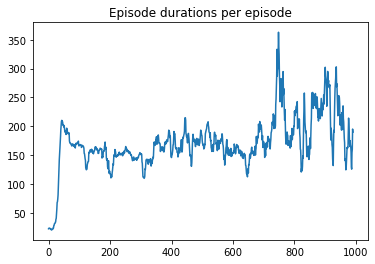

In [24]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')

In [35]:
# Let's run it!
num_episodes = 1000
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen#
results={}
results2={}
counter=0
import datetime as datetime
x=datetime.datetime.now()
for seed in range(10):
    for semib in [True,False]:
        for epsilon in [0.0,.01,.05,.3]:
            for discount_factor in [0.5,.8,1]:
# We will seed the algorithm (before initializing QNetwork!) for reproducibility
                random.seed(seed)
                torch.manual_seed(seed)
                env.seed(seed)

                Q_net = QNetwork(num_hidden)
                policy = EpsilonGreedyPolicy(Q_net, epsilon)
                episode_durations1 = run_episodes(train, Q_net, policy, memory, env, num_episodes, batch_size, discount_factor, learn_rate,semi=semib)
                
                results[counter]={'EpisodeDuration':episode_durations1,'Seed':seed,'SemiB':semib,'Epsilon':epsilon,'DisFactor':discount_factor}
                results2[counter]={'DQN':Q_net,'EpisodeDuration':episode_durations1,'Seed':seed,'SemiB':semib,'Epsilon':epsilon,'DisFactor':discount_factor}

                counter=counter+1
    print(datetime.datetime.now()-x)
results11=pd.DataFrame(results).T
results11.to_hdf('results.h5','df')

[ 0.10855442  1.033291   -0.21523873 -1.764768  ]
 Episode 0 finished after 21 steps
[-0.20872381 -1.12896095  0.22587624  1.85854379]
 Episode 10 finished after 24 steps
[-0.21781589 -0.95646255  0.21659326  1.66353302]
 Episode 20 finished after 19 steps
[-0.12762897 -0.41944539  0.22160612  0.9441528 ]
 Episode 30 finished after 14 steps
[-0.12988406  0.02178096  0.2233155   0.59432078]
 Episode 40 finished after 22 steps
[ 0.9953551   1.17381933 -0.21340011 -1.19704408]
 Episode 50 finished after 146 steps
[ 0.68494289  2.47850691 -0.25999455 -3.26703972]
 Episode 60 finished after 95 steps
[ 0.13647352  2.5298108  -0.26192765 -3.64240862]
 Episode 70 finished after 57 steps
[ 0.28230639  2.83614296 -0.22344124 -3.37825072]
 Episode 80 finished after 67 steps
[ 0.77681332  2.12503607 -0.21833752 -2.48501585]
 Episode 90 finished after 125 steps
[ 1.00785464  2.48262647 -0.22313914 -3.03791393]
 Episode 100 finished after 85 steps
[ 0.20369962  1.91468236 -0.23017575 -2.63345841]
 E

 Episode 390 finished after 168 steps
[-2.41501625 -1.12834912 -0.19574788 -0.0650063 ]
 Episode 400 finished after 272 steps
[ 2.41889747  1.98875475  0.1232446  -0.52680941]
 Episode 410 finished after 163 steps
[ 2.41045606  1.9885759   0.19471993 -0.22255044]
 Episode 420 finished after 373 steps
[ 0.77354371  1.70814351 -0.22852162 -0.8345432 ]
 Episode 430 finished after 283 steps
[2.40603336 1.62739191 0.2109486  0.10433392]
 Episode 440 finished after 253 steps
[1.41763173 1.46287603 0.21220105 0.028253  ]
 Episode 450 finished after 116 steps
[-0.00827078  0.34426823  0.21038997  0.05116496]
 Episode 460 finished after 78 steps
[ 0.39883413  0.62059229 -0.22585406 -0.69694845]
 Episode 470 finished after 73 steps
[ 1.08780175 -0.77936478  0.21766596  1.03134052]
 Episode 480 finished after 284 steps
[ 0.29131138 -0.19154708  0.20972785  0.62603943]
 Episode 490 finished after 81 steps
[ 0.04439143  0.58732991 -0.2172184  -1.12729233]
 Episode 500 finished after 55 steps
[ 2.41

[-1.47507889 -3.0153569   0.22969005  2.11924591]
 Episode 390 finished after 88 steps
[ 0.51502747  1.26920238 -0.2273257  -0.82219916]
 Episode 400 finished after 135 steps
[-0.53735669 -0.22824109  0.21553261  0.25078176]
 Episode 410 finished after 177 steps
[ 0.3049134   1.09730347  0.01496541 -0.61481839]
 Episode 420 finished after 500 steps
[-0.09592133  0.00532316  0.21071195  0.65923154]
 Episode 430 finished after 22 steps
[-0.08171724 -0.03063187  0.21434455  0.58684824]
 Episode 440 finished after 16 steps
[-0.11008458 -0.20574507  0.2185068   0.75043356]
 Episode 450 finished after 19 steps
[-0.05609702 -0.04172594  0.21040073  0.55362205]
 Episode 460 finished after 16 steps
[-0.07765529 -0.16937859  0.21032019  0.71425295]
 Episode 470 finished after 17 steps
[-0.12730288 -0.03215878  0.21070877  0.58443425]
 Episode 480 finished after 26 steps
[-0.0100671   0.16535308  0.2169148   0.7806129 ]
 Episode 490 finished after 43 steps
[0.2652015  0.88957982 0.20945772 0.2575

[-0.64294592 -0.92909004  0.21030964  0.30687698]
 Episode 480 finished after 49 steps
[ 0.33074813  0.1999378  -0.2121002   0.00072634]
 Episode 490 finished after 47 steps
[ 0.31324964  1.33516299 -0.22619207 -1.58927807]
 Episode 500 finished after 37 steps
[ 0.33998325  0.77418891 -0.21730498 -0.99830481]
 Episode 510 finished after 44 steps
[-0.38726112 -1.76075328  0.23109915  1.83133189]
 Episode 520 finished after 33 steps
[-0.39748263  0.27716047 -0.21251951 -1.14904909]
 Episode 530 finished after 87 steps
[-0.21756644 -1.2020429   0.23024886  1.59371081]
 Episode 540 finished after 32 steps
[-0.25086219 -1.18822416  0.22117817  1.63078317]
 Episode 550 finished after 24 steps
[-1.03997858  0.06322267 -0.23534119 -1.67744686]
 Episode 560 finished after 98 steps
[-0.55618205 -1.16426763  0.21603558  1.06968049]
 Episode 570 finished after 76 steps
[ 0.19490204  1.01255736 -0.22597847 -1.43948294]
 Episode 580 finished after 29 steps
[ 0.16125148  1.35431501 -0.2288734  -1.670

 Episode 450 finished after 375 steps
[-2.43248696 -2.00218471 -0.16447564 -0.34246647]
 Episode 460 finished after 239 steps
[-2.42771428 -1.79736222 -0.07738528  0.51094441]
 Episode 470 finished after 162 steps
[ 1.60341827  0.54031743 -0.21315884 -0.02176119]
 Episode 480 finished after 389 steps
[ 0.0364795   0.0484947  -0.21012984 -0.68412287]
 Episode 490 finished after 28 steps
[-2.41076169 -1.65918506 -0.17174607  0.32059043]
 Episode 500 finished after 397 steps
[-2.17290021 -1.25696044 -0.21072267 -0.30340521]
 Episode 510 finished after 199 steps
[-2.40088442 -1.68649763 -0.18415446  0.15487421]
 Episode 520 finished after 265 steps
[-2.42255697 -2.33324025 -0.20596277  0.30408203]
 Episode 530 finished after 277 steps
[ 0.30448173  0.1503888  -0.21703579 -0.20047651]
 Episode 540 finished after 41 steps
[-2.40423881 -0.92221271 -0.15446471 -0.26218868]
 Episode 550 finished after 331 steps
[-2.406602   -0.32609946 -0.15270393 -1.08340853]
 Episode 560 finished after 242 st

[0.23973209 0.6986206  0.21398096 0.38437101]
 Episode 390 finished after 68 steps
[0.00133334 0.30024907 0.22132362 0.52643401]
 Episode 400 finished after 120 steps
[ 0.02171972 -0.18688211 -0.21566271 -0.68208023]
 Episode 410 finished after 41 steps
[-0.02989916  0.01690034 -0.21964166 -0.87053668]
 Episode 420 finished after 30 steps
[ 0.06741606  0.06637597 -0.21284949 -0.71636382]
 Episode 430 finished after 36 steps
[ 0.14270491  0.21968411 -0.22081611 -0.95746882]
 Episode 440 finished after 43 steps
[ 0.12039386  0.2268753  -0.21496792 -0.80352465]
 Episode 450 finished after 19 steps
[ 0.18078993  0.58159632 -0.21133292 -1.19709903]
 Episode 460 finished after 17 steps
[ 0.15829682  0.26296007 -0.22472784 -0.83384466]
 Episode 470 finished after 19 steps
[ 0.08563644  0.40534573 -0.20944342 -1.0769952 ]
 Episode 480 finished after 16 steps
[ 0.03248277  0.05813263 -0.21872537 -0.90271608]
 Episode 490 finished after 26 steps
[ 0.0692892  -0.05291469  0.2169538   1.00675491]


[-0.29218117 -0.52877021  0.21649803  0.61783246]
 Episode 470 finished after 75 steps
[-0.9688837  -1.52564596  0.21095495  1.45332471]
 Episode 480 finished after 96 steps
[ 1.9281736   1.53884058 -0.22460441 -1.48727648]
 Episode 490 finished after 108 steps
[-0.1636273   0.01253296 -0.21995058 -0.46919082]
 Episode 500 finished after 60 steps
[ 0.45754702  0.94887088 -0.22564717 -0.83891931]
 Episode 510 finished after 61 steps
[ 0.11538512  0.16495564 -0.21166252 -0.58729221]
 Episode 520 finished after 13 steps
[-0.0578085   0.43879716 -0.21220761 -0.69461536]
 Episode 530 finished after 64 steps
[ 0.57921151  2.05246858 -0.23345088 -2.08660161]
 Episode 540 finished after 53 steps
[-0.36584432 -1.94091772  0.22061076  2.19845122]
 Episode 550 finished after 36 steps
[-0.15104666 -1.1919209   0.23186552  2.02574208]
 Episode 560 finished after 12 steps
[-0.06098323 -0.4326663   0.22032931  0.97597844]
 Episode 570 finished after 32 steps
[ 0.59270152  1.94375629 -0.23336344 -1.93

[ 0.39730819 -0.9329315   0.21174797  0.74464757]
 Episode 450 finished after 163 steps
[-2.42447136 -1.99373545 -0.16848509 -0.53169075]
 Episode 460 finished after 195 steps
[-2.43443291 -1.76629657 -0.19522143 -0.18065372]
 Episode 470 finished after 198 steps
[-1.25402988 -1.50653157  0.21076766  1.02419726]
 Episode 480 finished after 254 steps
[-2.4017582  -0.49492761 -0.14252078 -0.72385654]
 Episode 490 finished after 203 steps
[-2.40822666 -0.9107906  -0.15748192 -0.14996852]
 Episode 500 finished after 245 steps
[-0.46311714 -0.33928851 -0.22320937 -0.49463769]
 Episode 510 finished after 124 steps
[-2.41224049 -1.87213755 -0.15057317  0.23802724]
 Episode 520 finished after 124 steps
[ 2.41897864  1.87499937  0.17047536 -0.27429494]
 Episode 530 finished after 252 steps
[0.03018225 0.3224375  0.2117519  0.02056126]
 Episode 540 finished after 46 steps
[-2.42347139 -1.28488451 -0.17991438 -0.28653281]
 Episode 550 finished after 409 steps
[-2.40960974 -1.28035102 -0.17658753 

[-0.11841562 -0.6138564   0.21585873  1.27369985]
 Episode 390 finished after 13 steps
[-0.13608142 -0.82885465  0.20957179  1.37857677]
 Episode 400 finished after 20 steps
[-0.10143163 -0.82749961  0.22726563  1.46276126]
 Episode 410 finished after 12 steps
[-0.21106638 -0.62044601  0.23268985  1.20280939]
 Episode 420 finished after 15 steps
[-0.15014899 -0.56681954  0.2267337   1.26083093]
 Episode 430 finished after 13 steps
[-0.10334968 -0.02414108  0.21826081  0.44088271]
 Episode 440 finished after 12 steps
[-0.1374814  -0.58949142  0.23665737  1.20620708]
 Episode 450 finished after 13 steps
[-0.0664781  -0.42794085  0.21387581  1.06054602]
 Episode 460 finished after 14 steps
[-0.09073305 -0.55625745  0.21922622  1.23723467]
 Episode 470 finished after 15 steps
[-0.14813623 -0.41351158  0.21076704  0.98130164]
 Episode 480 finished after 18 steps
[-0.13430654 -0.00530066  0.22235644  0.52880241]
 Episode 490 finished after 22 steps
[0.06022699 0.71712791 0.21255972 0.0455869

[ 9.57130681e-04  5.86775907e-01 -2.19399150e-01 -1.06982105e+00]
 Episode 480 finished after 57 steps
[ 0.54905153  1.71344971 -0.2158898  -1.32142896]
 Episode 490 finished after 107 steps
[ 1.36532091  1.86450159 -0.22313075 -1.22409104]
 Episode 500 finished after 96 steps
[ 0.07601836 -0.77242941  0.21867927  1.07128753]
 Episode 510 finished after 104 steps
[ 0.14861667  0.15554693 -0.20949152 -0.37525445]
 Episode 520 finished after 25 steps
[ 1.01258557  0.85300146 -0.23184567 -1.83597301]
 Episode 530 finished after 204 steps
[2.42982043 1.77619479 0.18988801 0.04477649]
 Episode 540 finished after 188 steps
[-0.74282091 -0.94186608  0.21080642  0.17765618]
 Episode 550 finished after 49 steps
[-2.40925377 -2.01451354 -0.17786328  0.070702  ]
 Episode 560 finished after 177 steps
[2.44584887 2.14629087 0.17758525 0.22902985]
 Episode 570 finished after 140 steps
[ 2.42636395  2.58923826  0.2036308  -0.08703648]
 Episode 580 finished after 116 steps
[-1.30491116 -2.06406802  0.

[-2.42667176 -1.44236375 -0.16277467 -0.37973757]
 Episode 440 finished after 232 steps
[-0.28556739 -0.55600814  0.21679608  0.44763971]
 Episode 450 finished after 33 steps
[-0.2156699  -0.54038035 -0.21141985 -0.50258525]
 Episode 460 finished after 49 steps
[-2.41897007 -1.58913283 -0.19585948 -0.0740168 ]
 Episode 470 finished after 277 steps
[-2.42493501 -1.82941264 -0.18228715  0.10643911]
 Episode 480 finished after 162 steps
[ 2.41536134  3.1140072   0.13782038 -0.09826436]
 Episode 490 finished after 303 steps
[-0.81801644 -0.55333852 -0.21372395 -0.0102426 ]
 Episode 500 finished after 255 steps
[2.45536229 3.08414736 0.08879971 0.21749153]
 Episode 510 finished after 293 steps
[ 0.64325046 -0.05556954  0.21362235  0.28421674]
 Episode 520 finished after 134 steps
[-2.42633695 -1.57454616 -0.18778251 -0.39987966]
 Episode 530 finished after 171 steps
[-0.77550569 -1.15177091  0.21161193  0.45765127]
 Episode 540 finished after 436 steps
[-0.12745315  0.39277836 -0.21223106 -

[ 0.1443989   0.58555433 -0.21908034 -1.16648255]
 Episode 390 finished after 15 steps
[ 0.15683801  0.75097295 -0.22035449 -1.43575835]
 Episode 400 finished after 10 steps
[ 0.16295523  0.37129905 -0.2140784  -0.9657552 ]
 Episode 410 finished after 16 steps
[ 0.0652456   0.57640471 -0.21076908 -1.18212137]
 Episode 420 finished after 11 steps
[ 0.11477873  0.63476436 -0.21406853 -1.22987859]
 Episode 430 finished after 15 steps
[ 0.15566033  0.2122941  -0.22946334 -0.7924197 ]
 Episode 440 finished after 25 steps
[ 0.1338318   0.41540603 -0.21099912 -0.95294998]
 Episode 450 finished after 14 steps
[ 0.16781371  0.19777132 -0.21125207 -0.74490946]
 Episode 460 finished after 23 steps
[ 0.09379619 -0.1108334  -0.21369546 -0.60487624]
 Episode 470 finished after 33 steps
[ 0.05638984 -0.16695286 -0.2201352  -0.4768147 ]
 Episode 480 finished after 21 steps
[ 0.03248696 -0.33012111 -0.21884074 -0.34932297]
 Episode 490 finished after 26 steps
[ 0.13339211  0.21097634 -0.21168892 -0.841

[ 0.25988389  0.94944636 -0.21605732 -1.09160812]
 Episode 500 finished after 27 steps
[-0.07231941 -0.7825701   0.21571314  1.29852775]
 Episode 510 finished after 44 steps
[ 1.68328689  2.38152804 -0.21351214 -1.36071313]
 Episode 520 finished after 93 steps
[-0.05190098 -1.31914193  0.21445942  2.03343888]
 Episode 530 finished after 39 steps
[ 0.41982168 -0.10021482  0.22820064  1.35156849]
 Episode 540 finished after 58 steps
[-0.39097643 -1.36584616  0.22473538  1.53727634]
 Episode 550 finished after 57 steps
[ 1.04062463 -1.62142498  0.20951263  3.48537291]
 Episode 560 finished after 88 steps
[ 0.18299322  0.35721877 -0.21074171 -0.43277343]
 Episode 570 finished after 48 steps
[ 0.06934511 -0.36303785  0.219286    0.87591645]
 Episode 580 finished after 52 steps
[-0.67127777 -1.50050547  0.22246395  1.19697209]
 Episode 590 finished after 64 steps
[ 0.14765716  2.37940007 -0.26067739 -3.76318364]
 Episode 600 finished after 108 steps
[-0.17435595 -0.20366798  0.21063763  0.56

[ 0.34291162  1.71445988 -0.25384109 -2.15255143]
 Episode 460 finished after 27 steps
[ 2.4348957   1.87069055  0.06289137 -0.17729965]
 Episode 470 finished after 190 steps
[2.41372571 1.43545343 0.14281543 0.29216736]
 Episode 480 finished after 206 steps
[ 2.4179888   2.22521349  0.13792507 -0.55580421]
 Episode 490 finished after 130 steps
[2.42861186 2.17363016 0.17332988 0.00674568]
 Episode 500 finished after 112 steps
[ 2.43969139  2.1993543   0.17260138 -0.32893169]
 Episode 510 finished after 130 steps
[ 2.34016624  2.14196893  0.21021874 -0.06220012]
 Episode 520 finished after 174 steps
[-2.41440681 -1.58399542 -0.16623212 -0.18774247]
 Episode 530 finished after 313 steps
[2.41943675 1.58806099 0.20517554 0.18573319]
 Episode 540 finished after 245 steps
[ 2.42634735  2.01811516  0.11942054 -0.94484952]
 Episode 550 finished after 231 steps
[-2.42259268 -2.04147038 -0.13557195  0.67033721]
 Episode 560 finished after 179 steps
[ 0.50203629 -0.25115457  0.22478419  0.98443

[-1.32862951  0.24765425 -0.24293184 -1.76204655]
 Episode 380 finished after 143 steps
[2.4046629  0.87301715 0.02119468 0.54024878]
 Episode 390 finished after 457 steps
[-1.93453275 -3.28228796  0.24026129  3.39596897]
 Episode 400 finished after 179 steps
[2.42386313 1.20689274 0.08345486 0.680931  ]
 Episode 410 finished after 205 steps
[2.42236235 1.23071614 0.04612855 0.4538695 ]
 Episode 420 finished after 277 steps
[-0.86172125  0.27785676 -0.2325748  -1.38761978]
 Episode 430 finished after 211 steps
[-1.61648985 -2.87652705  0.24142811  3.25087386]
 Episode 440 finished after 397 steps
[-1.06848697  0.64111385 -0.25247107 -1.95379846]
 Episode 450 finished after 245 steps
[-1.29327154 -2.89703106  0.26091445  3.44390593]
 Episode 460 finished after 467 steps
[-1.17870753 -2.82199389  0.25184708  3.12963223]
 Episode 470 finished after 477 steps
[-0.72530461 -0.04718169  0.21568688  0.92272022]
 Episode 480 finished after 270 steps
[-0.17090394  0.73192519  0.21743981  0.3062

 Episode 380 finished after 12 steps
[-0.18541763 -1.35286144  0.23199324  1.53965968]
 Episode 390 finished after 63 steps
[-0.37177235 -1.94893407  0.22264939  2.03316519]
 Episode 400 finished after 32 steps
[ 0.86036701  2.23372223 -0.21553908 -1.95227361]
 Episode 410 finished after 74 steps
[ 1.36996833  1.65355182 -0.21160286 -0.86905157]
 Episode 420 finished after 97 steps
[-0.23649703 -1.31510441  0.22898407  1.73148835]
 Episode 430 finished after 25 steps
[ 0.25738321  1.1589744  -0.2328944  -1.63677356]
 Episode 440 finished after 28 steps
[ 0.18419032  0.9832525  -0.21685347 -1.45506471]
 Episode 450 finished after 29 steps
[-0.83048341 -1.50798016  0.21301288  0.81210638]
 Episode 460 finished after 68 steps
[ 0.26036661  1.58776575 -0.21247514 -1.99512609]
 Episode 470 finished after 24 steps
[-0.04616486 -1.16917068  0.22560971  1.62028001]
 Episode 480 finished after 70 steps
[-0.69746939 -1.69941834  0.23230944  1.82587689]
 Episode 490 finished after 85 steps
[ 0.16

 Episode 460 finished after 258 steps
[-2.42199856 -1.58307101 -0.19993247 -0.21092229]
 Episode 470 finished after 187 steps
[ 2.44373926  2.91738316  0.11786863 -0.31129367]
 Episode 480 finished after 412 steps
[ 2.4314303   2.40316902  0.09748511 -0.46546626]
 Episode 490 finished after 473 steps
[-2.41894194 -1.07940614 -0.17988097 -0.44672001]
 Episode 500 finished after 184 steps
[-0.7288528  -0.75032903  0.22040159  0.57386705]
 Episode 510 finished after 156 steps
[-2.41177307 -1.49876535 -0.1942987   0.02299981]
 Episode 520 finished after 274 steps
[ 0.14084846 -0.35749001  0.22207034  0.85894901]
 Episode 530 finished after 64 steps
[-2.42341683 -1.47745146 -0.22108187 -0.39884026]
 Episode 540 finished after 276 steps
[-2.39336094 -1.09353907 -0.21255841 -0.50254708]
 Episode 550 finished after 226 steps
[-0.91725145  0.01252546 -0.21773582 -0.53123124]
 Episode 560 finished after 148 steps
[-2.4427261  -2.37717353 -0.21443352 -0.28344957]
 Episode 570 finished after 133 s

 Episode 380 finished after 174 steps
[ 2.12630483  3.40387267 -0.25866995 -3.22143263]
 Episode 390 finished after 194 steps
[ 2.24358998  2.99843879 -0.25796181 -2.92099367]
 Episode 400 finished after 208 steps
[ 1.79725295  3.18387276 -0.23818481 -2.87954961]
 Episode 410 finished after 191 steps
[ 2.3133017   3.39660475 -0.22725675 -3.25950053]
 Episode 420 finished after 188 steps
[ 1.95271903  2.69927999 -0.26432721 -2.69563439]
 Episode 430 finished after 166 steps
[ 2.26504756  3.78833998 -0.26603041 -3.53392681]
 Episode 440 finished after 162 steps
[1.05854513 1.09805855 0.21227548 0.05463756]
 Episode 450 finished after 140 steps
[ 2.04168229  3.78473943 -0.26419568 -3.73330692]
 Episode 460 finished after 176 steps
[ 1.9484244   2.88720305 -0.23477715 -2.59894577]
 Episode 470 finished after 151 steps
[ 2.12959389  2.85119983 -0.21192829 -2.90837983]
 Episode 480 finished after 193 steps
[ 2.22181082  3.2429393  -0.24476847 -3.0111159 ]
 Episode 490 finished after 193 step

[ 0.18338574  0.76872888 -0.22259937 -1.19710518]
 Episode 390 finished after 20 steps
[-0.19144297 -0.81146161  0.2108475   0.98840356]
 Episode 400 finished after 30 steps
[-0.07521718 -0.56989559 -0.21162566 -0.2461506 ]
 Episode 410 finished after 39 steps
[-0.02513547 -0.02037703 -0.2113009  -0.02950385]
 Episode 420 finished after 102 steps
[ 0.04229594  0.25104362 -0.2125126  -0.77937949]
 Episode 430 finished after 47 steps
[ 0.19526352  0.39080652 -0.22228317 -0.71572368]
 Episode 440 finished after 26 steps
[ 0.20370472  0.20955898 -0.21054218 -0.41292437]
 Episode 450 finished after 57 steps
[-0.60212294 -0.94004416  0.21192508  0.30814009]
 Episode 460 finished after 81 steps
[-0.97663479 -2.41088186  0.23357984  2.05455451]
 Episode 470 finished after 75 steps
[-0.35657612 -2.30842014  0.24004471  2.70865967]
 Episode 480 finished after 46 steps
[-0.64130032 -1.88159528  0.23816866  1.83595488]
 Episode 490 finished after 70 steps
[ 0.18094494  0.19306289 -0.21015285 -0.43

[ 2.41826941  1.70008239  0.15190663 -0.43016185]
 Episode 470 finished after 151 steps
[ 2.40757661  1.82307674  0.18376132 -0.24294661]
 Episode 480 finished after 182 steps
[1.82452026 0.56333836 0.21073051 0.00715276]
 Episode 490 finished after 167 steps
[2.2985915  0.89740514 0.209703   0.08062058]
 Episode 500 finished after 163 steps
[2.24398178 0.71020198 0.16184132 0.43973033]
 Episode 510 finished after 500 steps
[-0.03855224  0.11959999  0.21522706  0.43494148]
 Episode 520 finished after 47 steps
[2.40074731 0.95195365 0.19936441 0.03516337]
 Episode 530 finished after 241 steps
[2.40670176 0.84986933 0.20957607 0.42874431]
 Episode 540 finished after 247 steps
[-2.41258729 -1.85380946 -0.14056729  0.23545437]
 Episode 550 finished after 148 steps
[-2.40880202 -1.06900617 -0.07668378 -0.73237833]
 Episode 560 finished after 220 steps
[-2.40268702 -0.51957542  0.01483266 -1.13951793]
 Episode 570 finished after 127 steps
[-2.42108172 -1.75713359 -0.08883106 -0.48407865]
 Ep

[ 1.60119331  3.78327077 -0.2180363  -3.55194983]
 Episode 380 finished after 160 steps
[ 1.53010248  3.03263945 -0.22079986 -3.02802248]
 Episode 390 finished after 232 steps
[ 1.58163713  3.57613495 -0.2535913  -3.63998286]
 Episode 400 finished after 167 steps
[ 1.435717    3.39463619 -0.2510995  -3.53667541]
 Episode 410 finished after 230 steps
[-0.90689671 -0.7395171  -0.21640216 -0.21589713]
 Episode 420 finished after 274 steps
[ 1.48238859  3.45887109 -0.24256681 -3.40439746]
 Episode 430 finished after 150 steps
[ 1.42023515  3.0420615  -0.24564465 -3.09442834]
 Episode 440 finished after 124 steps
[ 1.37617285  2.68604246 -0.23590678 -2.94682053]
 Episode 450 finished after 252 steps
[ 1.46471496  2.84954261 -0.25789312 -3.14512314]
 Episode 460 finished after 235 steps
[ 1.44989404  2.91232874 -0.21583824 -3.14985727]
 Episode 470 finished after 201 steps
[-0.5660437  -1.02684785  0.21847536  2.50268487]
 Episode 480 finished after 421 steps
[ 1.26015559  3.07516097 -0.2228

[ 0.36220978  1.132526   -0.21094943 -1.2036738 ]
 Episode 380 finished after 48 steps
[-0.10766482 -0.99695013  0.21638164  1.70895201]
 Episode 390 finished after 29 steps
[-0.26321419 -2.37659627  0.26470568  3.49457153]
 Episode 400 finished after 62 steps
[-0.14868025 -0.23178509  0.2157576   0.33055997]
 Episode 410 finished after 23 steps
[-0.17948594 -1.01077491  0.23814931  1.80452417]
 Episode 420 finished after 59 steps
[-0.12607681 -0.16968111  0.21071479  0.50488923]
 Episode 430 finished after 31 steps
[-0.19676197 -0.77491708  0.21020469  0.96583103]
 Episode 440 finished after 122 steps
[-0.35352927 -2.68644342  0.23343091  3.37433111]
 Episode 450 finished after 82 steps
[ 0.10747281 -0.04431251  0.21543287  0.61230892]
 Episode 460 finished after 58 steps
[ 0.79380375 -0.60923384  0.2364499   2.43347392]
 Episode 470 finished after 95 steps
[ 0.23721948  1.13820024 -0.21726005 -1.20153539]
 Episode 480 finished after 28 steps
[-0.16347542 -0.38052609  0.22398964  0.78

[-2.43907395 -2.58457599 -0.17552023  0.48309168]
 Episode 460 finished after 154 steps
[2.40814202 0.91398965 0.21077929 0.88783038]
 Episode 470 finished after 159 steps
[-0.076975    0.75453294 -0.21323945 -0.75112448]
 Episode 480 finished after 126 steps
[-2.40154851 -1.43572495 -0.19536322 -0.02121023]
 Episode 490 finished after 458 steps
[2.40156043 0.89487458 0.03715026 0.13475822]
 Episode 500 finished after 225 steps
[ 0.71788876 -0.91974585  0.21760817  0.29422869]
 Episode 510 finished after 281 steps
[ 0.38323724 -0.82394749  0.21301794  1.2060044 ]
 Episode 520 finished after 98 steps
[ 2.12775162  0.62669227 -0.21838075 -0.83077012]
 Episode 530 finished after 281 steps
[2.41577805 1.03097775 0.13971008 0.43991084]
 Episode 540 finished after 208 steps
[2.42131072 1.61155971 0.19825346 0.00749523]
 Episode 550 finished after 175 steps
[ 1.50533492  0.36058022 -0.21040558 -0.17849661]
 Episode 560 finished after 194 steps
[ 2.41613198  1.82311818  0.16465134 -0.67885719]

 Episode 380 finished after 200 steps
[-0.66300948  1.5861018  -0.25785342 -3.23780247]
 Episode 390 finished after 270 steps
[-0.79161325 -2.5592218   0.26561735  3.51274959]
 Episode 400 finished after 181 steps
[ 0.78813338 -0.7904854  -0.03320574  0.61426544]
 Episode 410 finished after 500 steps
[-0.49390041  1.75091857 -0.2118312  -3.04885739]
 Episode 420 finished after 227 steps
[-0.4278622   1.44162662 -0.22453693 -3.01476279]
 Episode 430 finished after 355 steps
[-0.26447459 -1.07942137 -0.21873276 -0.36735844]
 Episode 440 finished after 278 steps
[-0.6180198  -2.5025547   0.26728356  3.35326991]
 Episode 450 finished after 115 steps
[-0.51624305  1.2016882  -0.23444497 -2.87867177]
 Episode 460 finished after 292 steps
[-0.42327863 -2.06254974  0.22014143  2.39294522]
 Episode 470 finished after 363 steps
[ 0.45121734 -0.63466301  0.2265794   1.86869789]
 Episode 480 finished after 223 steps
[1.0433195  0.50421203 0.23262301 1.34343986]
 Episode 490 finished after 423 step

[ 0.17939333  1.33145832 -0.22335166 -1.63744554]
 Episode 390 finished after 35 steps
[ 0.08224455  0.2066011  -0.21597906 -0.83087525]
 Episode 400 finished after 17 steps
[ 0.29093244  1.38469661 -0.21826792 -1.46161694]
 Episode 410 finished after 33 steps
[-0.10783366 -1.14234769  0.21840151  1.66196174]
 Episode 420 finished after 30 steps
[-0.01622292  2.32512935 -0.2473844  -3.5844482 ]
 Episode 430 finished after 68 steps
[ 0.30545636  1.12305312 -0.22414535 -1.09762306]
 Episode 440 finished after 46 steps
[ 0.27494985  1.70053694 -0.23828998 -2.1798385 ]
 Episode 450 finished after 25 steps
[ 1.00389843 -0.5535245   0.21420992  0.96264397]
 Episode 460 finished after 279 steps
[ 0.22125421  0.34601028 -0.21612833 -0.21877386]
 Episode 470 finished after 54 steps
[-0.09234936 -0.59943846  0.21710993  1.16755433]
 Episode 480 finished after 11 steps
[ 0.13407439  2.09578495 -0.23985643 -3.07281751]
 Episode 490 finished after 39 steps
[-0.23147617 -0.6338972   0.22297162  1.06

[2.40892555 0.55461155 0.13652674 0.57260452]
 Episode 460 finished after 359 steps
[-2.42881824 -2.21634486 -0.17640568  0.15211864]
 Episode 470 finished after 208 steps
[ 2.40438468  1.82475227 -0.10451261 -0.18479482]
 Episode 480 finished after 142 steps
[0.1685811  0.48073524 0.2123348  0.54021813]
 Episode 490 finished after 43 steps
[-2.41584985 -1.67330706 -0.20706805 -0.10362454]
 Episode 500 finished after 171 steps
[2.41039475 2.33421241 0.11382735 0.21273467]
 Episode 510 finished after 141 steps
[-2.40433349 -1.81953709 -0.1951456  -0.43475191]
 Episode 520 finished after 190 steps
[-0.11494783  0.01900346  0.21982474  0.32912739]
 Episode 530 finished after 14 steps
[2.40211353 0.17119176 0.05789062 0.53082536]
 Episode 540 finished after 189 steps
[-2.04335596 -2.05765251  0.22405987  0.86137353]
 Episode 550 finished after 139 steps
[-0.30457007 -0.15314596 -0.21582847 -0.36234789]
 Episode 560 finished after 139 steps
[-0.67406201 -1.27730299  0.22575543  1.03591338]


[ 0.05280149  0.39720843 -0.21258894 -1.07273996]
 Episode 390 finished after 18 steps
[ 0.05460462 -0.17585816 -0.22161268 -0.40898983]
 Episode 400 finished after 27 steps
[ 0.10656389  0.2688463  -0.21099318 -0.90378912]
 Episode 410 finished after 19 steps
[ 0.1448368  -0.13973632 -0.2132894  -0.44066199]
 Episode 420 finished after 31 steps
[ 0.13352562  0.01657883 -0.210831   -0.7320968 ]
 Episode 430 finished after 38 steps
[ 0.04519421 -0.17674881 -0.21394268 -0.49101079]
 Episode 440 finished after 29 steps
[ 0.05590444 -0.38319479 -0.21753864 -0.29641323]
 Episode 450 finished after 36 steps
[ 0.02486839 -0.50412669 -0.21465743 -0.15001899]
 Episode 460 finished after 41 steps
[ 0.00433077 -0.37313438 -0.21921493 -0.40512385]
 Episode 470 finished after 32 steps
[ 0.1378816  -0.16591084 -0.22182587 -0.40668104]
 Episode 480 finished after 23 steps
[-0.03848808 -0.57691349 -0.21223501 -0.21348736]
 Episode 490 finished after 35 steps
[-2.41569007 -2.9943955   0.038695    0.959

 Episode 490 finished after 119 steps
[ 0.21594664  2.07255876 -0.24131366 -2.56284013]
 Episode 500 finished after 29 steps
[ 0.65578982  1.86864366 -0.21575353 -1.58395182]
 Episode 510 finished after 56 steps
[ 0.21870839 -1.01644988  0.21913317  1.95271317]
 Episode 520 finished after 53 steps
[ 0.49197949  1.35986922 -0.21745323 -1.20174861]
 Episode 530 finished after 49 steps
[ 0.4318793   1.34237351 -0.22135922 -1.26326838]
 Episode 540 finished after 37 steps
[ 0.32037875  1.31343517 -0.21127817 -1.34182306]
 Episode 550 finished after 39 steps
[ 0.14294078  0.21871134 -0.21113062 -0.54551318]
 Episode 560 finished after 11 steps
[ 0.38672593  1.37530232 -0.22244819 -1.37118226]
 Episode 570 finished after 33 steps
[ 0.18355946  1.15162329 -0.22826548 -1.50140365]
 Episode 580 finished after 30 steps
[ 0.20274383  1.5607391  -0.22538517 -1.8384498 ]
 Episode 590 finished after 28 steps
[-0.10317536 -0.74533976  0.21359652  1.18383436]
 Episode 600 finished after 24 steps
[-0.0

[-2.40527947 -1.75332965 -0.197172   -0.68244054]
 Episode 460 finished after 130 steps
[-1.77545914 -1.46389957 -0.21052454 -0.41161637]
 Episode 470 finished after 160 steps
[ 0.41642063  1.31774771 -0.21600769 -1.05593559]
 Episode 480 finished after 53 steps
[ 0.45721009 -0.10227245  0.21327922  1.38263131]
 Episode 490 finished after 126 steps
[-2.40912773 -1.48452764 -0.19024085 -0.25859507]
 Episode 500 finished after 184 steps
[ 0.28626231  1.12351393 -0.21155275 -1.1847979 ]
 Episode 510 finished after 52 steps
[ 2.40280341  1.25392161  0.17331377 -0.03110863]
 Episode 520 finished after 187 steps
[-0.13209842 -0.55924714  0.23278713  1.06891713]
 Episode 530 finished after 11 steps
[ 2.43253142  1.83296685  0.20065463 -0.0243724 ]
 Episode 540 finished after 272 steps
[2.4024264  1.97567727 0.185645   0.12320918]
 Episode 550 finished after 149 steps
[2.25718154 2.00681281 0.21276856 0.13896209]
 Episode 560 finished after 149 steps
[ 1.3085413   0.04110186 -0.21277481  0.010

[ 0.03989851 -0.02435122 -0.20979365 -0.57451474]
 Episode 380 finished after 18 steps
[-0.00431824 -0.17076133 -0.22497252 -0.570132  ]
 Episode 390 finished after 29 steps
[ 0.03181133 -0.17038982 -0.22160023 -0.53244189]
 Episode 400 finished after 31 steps
[ 0.115897    0.2677326  -0.21764122 -0.87994755]
 Episode 410 finished after 17 steps
[ 0.147304    0.0559414  -0.2174582  -0.75266609]
 Episode 420 finished after 28 steps
[ 0.09527784 -0.16964001 -0.21463238 -0.63436632]
 Episode 430 finished after 33 steps
[-0.01857861 -0.55167649 -0.21528668 -0.23806724]
 Episode 440 finished after 35 steps
[ 0.11131397 -0.19915956 -0.20954459 -0.34506502]
 Episode 450 finished after 23 steps
[ 0.04576888 -0.31432243 -0.20953007 -0.32903925]
 Episode 460 finished after 40 steps
[-0.12580805 -0.74438026 -0.21333654 -0.23460111]
 Episode 470 finished after 50 steps
[ 0.10466829 -0.35451082 -0.21567872 -0.253959  ]
 Episode 480 finished after 28 steps
[ 0.0460814  -0.20250521 -0.21278172 -0.454

[-0.33809007 -1.19742977  0.21568981  1.46459016]
 Episode 500 finished after 32 steps
[-0.10960251 -0.6170583   0.22458601  1.15697127]
 Episode 510 finished after 29 steps
[ 0.17296982 -0.25694246  0.2125078   1.22997344]
 Episode 520 finished after 41 steps
[-0.89974909 -0.15152344  0.21281897  0.07315332]
 Episode 530 finished after 123 steps
[ 0.17176704  0.60471609 -0.2169968  -1.03123162]
 Episode 540 finished after 17 steps
[ 0.23277555  1.33003632 -0.22979186 -1.72072963]
 Episode 550 finished after 23 steps
[ 0.1823047   0.98536175 -0.21028606 -1.4272077 ]
 Episode 560 finished after 23 steps
[ 0.00892373  0.22049712 -0.21003891  0.06520307]
 Episode 570 finished after 113 steps
[ 0.17460487  0.77241319 -0.22250785 -1.15053044]
 Episode 580 finished after 42 steps
[-0.11220081 -0.12863456 -0.21211717 -0.64893604]
 Episode 590 finished after 47 steps
[ 0.31673047  1.97047491 -0.24198833 -2.64947114]
 Episode 600 finished after 44 steps
[ 0.1615735   1.1739736  -0.22283889 -1.5

[-2.4008173  -1.10793505 -0.14557653 -0.35190092]
 Episode 450 finished after 240 steps
[ 0.20967688  0.41791813 -0.21992613 -0.43875916]
 Episode 460 finished after 24 steps
[0.02911031 0.31022786 0.22336603 0.58952122]
 Episode 470 finished after 256 steps
[2.42025369 1.63071229 0.19921928 0.0864999 ]
 Episode 480 finished after 217 steps
[-2.06191877 -1.12085778 -0.21774256 -0.24946329]
 Episode 490 finished after 126 steps
[-0.2156411   0.85970495  0.21332168  0.18664996]
 Episode 500 finished after 157 steps
[-2.41046345 -0.89533149 -0.13813179 -0.75955271]
 Episode 510 finished after 201 steps
[-1.40101768 -1.50015058  0.22507237  0.56415318]
 Episode 520 finished after 136 steps
[-2.40461064 -1.05102297 -0.1620731  -0.14450213]
 Episode 530 finished after 218 steps
[-0.42502935 -1.31132862  0.21806759  1.16646547]
 Episode 540 finished after 89 steps
[-2.40754392 -1.98922412 -0.12550732 -0.67349074]
 Episode 550 finished after 219 steps
[-2.41526447 -1.07035723 -0.19504508 -0.18

[ 0.07253751  0.58568107 -0.21557848 -1.22214547]
 Episode 390 finished after 13 steps
[ 0.07313416  0.20769268 -0.21841278 -0.85602002]
 Episode 400 finished after 25 steps
[ 0.07703982  0.08333229 -0.21747906 -0.82261002]
 Episode 410 finished after 26 steps
[ 0.17170031  0.04827268 -0.21380386 -0.57938496]
 Episode 420 finished after 26 steps
[ 0.17951982  0.19988512 -0.22363442 -0.76679888]
 Episode 430 finished after 21 steps
[ 0.08718117  0.20198344 -0.21340483 -0.82923915]
 Episode 440 finished after 23 steps
[ 0.11016587 -0.00146088 -0.22772539 -0.70446313]
 Episode 450 finished after 26 steps
[ 0.07584866 -0.12404683 -0.21599848 -0.51941708]
 Episode 460 finished after 41 steps
[ 0.04684437 -0.18782389 -0.2139707  -0.48258606]
 Episode 470 finished after 27 steps
[ 0.10811169  0.03284169 -0.20948254 -0.78594797]
 Episode 480 finished after 26 steps
[-0.10024786 -0.76170731 -0.215495   -0.14723503]
 Episode 490 finished after 44 steps
[-0.01688339 -0.20022778 -0.20990092 -0.515

 Episode 490 finished after 22 steps
[-0.2386562  -0.04897665  0.20993028  0.1736828 ]
 Episode 500 finished after 22 steps
[-2.20679908 -2.05612341  0.21317774  0.80103921]
 Episode 510 finished after 99 steps
[ 0.69747557  1.30995225 -0.22229204 -1.29465538]
 Episode 520 finished after 105 steps
[ 1.86385448  2.82260425 -0.21175651 -1.37850158]
 Episode 530 finished after 83 steps
[ 0.44006004  2.90073685 -0.25970108 -3.61048263]
 Episode 540 finished after 61 steps
[-0.2278782   1.00122034 -0.25272699 -2.51621551]
 Episode 550 finished after 51 steps
[ 0.24418687 -1.1763291   0.24627751  2.21378723]
 Episode 560 finished after 76 steps
[-0.85757872 -0.8777689   0.21190585  0.22618329]
 Episode 570 finished after 183 steps
[-0.17995341 -0.79234012  0.21931929  1.32810068]
 Episode 580 finished after 12 steps
[-0.21008295 -0.56747269  0.21853776  1.04366849]
 Episode 590 finished after 13 steps
[-0.37454689 -1.10315824  0.22181018  1.05373632]
 Episode 600 finished after 58 steps
[ 0.

[-2.42052186e+00 -1.48744578e+00 -1.69164336e-01  4.99395284e-05]
 Episode 450 finished after 322 steps
[-0.37466325  0.19874258  0.21292182  0.40304702]
 Episode 460 finished after 425 steps
[ 1.03989303 -0.06150569  0.21754086  0.76934232]
 Episode 470 finished after 124 steps
[-0.22121262  0.5516813  -0.21138564 -0.1845129 ]
 Episode 480 finished after 165 steps
[-1.18937002 -0.77842334  0.21088741  0.23091625]
 Episode 490 finished after 348 steps
[-0.24814221 -0.56582458 -0.21297846 -0.47288182]
 Episode 500 finished after 39 steps
[ 0.81433795  0.71421869 -0.21093467 -0.15923472]
 Episode 510 finished after 86 steps
[ 0.99728749 -0.06097168  0.22597259  0.91583865]
 Episode 520 finished after 114 steps
[ 2.42923043  1.67153239  0.18812615 -0.02950009]
 Episode 530 finished after 329 steps
[2.40239643 1.8290945  0.17818296 0.062437  ]
 Episode 540 finished after 156 steps
[2.41389349 1.61579138 0.15489273 0.03767717]
 Episode 550 finished after 303 steps
[-2.40675307 -0.69039792 -

[ 0.07638489  0.39280158 -0.22667757 -0.97652942]
 Episode 390 finished after 14 steps
[ 0.09686736  0.58813108 -0.21770602 -1.23230293]
 Episode 400 finished after 17 steps
[ 0.13290066  0.45262054 -0.21453136 -0.94757465]
 Episode 410 finished after 12 steps
[ 0.19272265  0.4279827  -0.21540375 -0.93982163]
 Episode 420 finished after 16 steps
[ 0.1916417   0.39074679 -0.229316   -0.97105386]
 Episode 430 finished after 18 steps
[ 0.11154434  0.58152621 -0.21040002 -1.18447667]
 Episode 440 finished after 15 steps
[ 0.16133388  0.76076993 -0.22064987 -1.48697913]
 Episode 450 finished after 14 steps
[ 0.11738858  0.63510885 -0.21676802 -1.23397602]
 Episode 460 finished after 17 steps
[ 0.11525589  0.38076815 -0.22638205 -1.00359899]
 Episode 470 finished after 16 steps
[ 0.17456761  0.21018757 -0.22134874 -0.68617351]
 Episode 480 finished after 15 steps
[ 0.08672158 -0.01778916 -0.21691432 -0.51966181]
 Episode 490 finished after 20 steps
[ 0.03144583 -0.0150416  -0.22241227 -0.592

 Episode 480 finished after 30 steps
[-0.30624016 -1.18961255  0.21530631  1.29897173]
 Episode 490 finished after 32 steps
[ 0.65388376  1.44545812 -0.21117968 -0.71893531]
 Episode 500 finished after 52 steps
[ 0.16673333 -0.19833519 -0.21279676 -0.08439624]
 Episode 510 finished after 15 steps
[ 0.96259383  1.4692469  -0.22017542 -0.78671401]
 Episode 520 finished after 70 steps
[ 0.20517333  0.42011727 -0.2226656  -0.51578043]
 Episode 530 finished after 44 steps
[ 0.35366437  0.95726024 -0.21342015 -0.77981095]
 Episode 540 finished after 45 steps
[ 0.17313738  1.74031062 -0.25675332 -2.78199136]
 Episode 550 finished after 11 steps
[-0.15523551 -1.74565903  0.24685632  2.74926872]
 Episode 560 finished after 21 steps
[ 0.33377302  1.58195546 -0.23921771 -1.93488872]
 Episode 570 finished after 34 steps
[ 0.1537042   1.14980415 -0.21108661 -1.45517134]
 Episode 580 finished after 30 steps
[0.68575401 0.73946223 0.2121381  0.27705105]
 Episode 590 finished after 82 steps
[ 0.206645

 Episode 460 finished after 357 steps
[ 0.59027836 -1.37189662  0.22149171  1.61253416]
 Episode 470 finished after 201 steps
[0.27232157 0.53844964 0.21556889 0.11334072]
 Episode 480 finished after 77 steps
[1.99752792 0.86303238 0.21228852 0.12114207]
 Episode 490 finished after 293 steps
[ 1.07815191 -0.81318218  0.21288713  1.0027657 ]
 Episode 500 finished after 242 steps
[ 0.58320148 -0.35847203 -0.00466383 -0.56079178]
 Episode 510 finished after 500 steps
[ 0.66746032  0.36288431 -0.06913744 -0.43305174]
 Episode 520 finished after 500 steps
[2.4061615  2.57548759 0.21431732 0.08978003]
 Episode 530 finished after 188 steps
[-0.55492442  0.35698701  0.21453246  0.4533537 ]
 Episode 540 finished after 228 steps
[-0.60917629 -1.14867337 -0.05134677  0.84830238]
 Episode 550 finished after 500 steps
[-0.54006878 -0.73573401  0.22047123  0.47369611]
 Episode 560 finished after 62 steps
[-0.84111186 -0.16366048  0.21053505  0.52633026]
 Episode 570 finished after 417 steps
[-2.4372

[ 2.31573165  2.23188748 -0.22958762 -2.2433743 ]
 Episode 380 finished after 184 steps
[1.92705538 1.43472255 0.21556211 0.13434037]
 Episode 390 finished after 190 steps
[ 2.25224403 -0.86886087  0.22799921  2.9109408 ]
 Episode 400 finished after 210 steps
[ 1.85638413  1.95911334 -0.21726383 -2.10833167]
 Episode 410 finished after 186 steps
[ 1.48765794 -2.48256078  0.26504016  3.19907122]
 Episode 420 finished after 177 steps
[ 1.54871687 -0.23309311  0.22366167  0.79778787]
 Episode 430 finished after 181 steps
[ 2.30312952  2.80430767 -0.22205843 -2.09810865]
 Episode 440 finished after 163 steps
[ 2.38829516  3.19212532 -0.21257984 -2.98999369]
 Episode 450 finished after 179 steps
[ 2.10320356  1.56654466 -0.22129567 -1.73343955]
 Episode 460 finished after 184 steps
[ 1.70557817  0.56540032 -0.22665592 -1.06582629]
 Episode 470 finished after 227 steps
[ 1.9044261   2.26122465 -0.22145317 -1.82595851]
 Episode 480 finished after 136 steps
[ 2.13020558  1.29844333 -0.23968226

[ 0.15314438  1.33454834 -0.21825846 -1.70504914]
 Episode 390 finished after 37 steps
[ 0.54138842  1.3058248  -0.21481649 -1.01368524]
 Episode 400 finished after 73 steps
[ 0.15194896  1.21708793 -0.23059405 -1.78551771]
 Episode 410 finished after 82 steps
[ 0.23907139  0.60888258 -0.22533296 -0.92020856]
 Episode 420 finished after 21 steps
[-0.20980971  0.06062073 -0.23422277 -1.72868545]
 Episode 430 finished after 46 steps
[ 0.07519173  1.14421487 -0.21291007 -1.56974412]
 Episode 440 finished after 48 steps
[-0.15470387 -0.42386349  0.21994291  0.62140636]
 Episode 450 finished after 22 steps
[-1.90609764 -2.83033761  0.21149966  3.07986307]
 Episode 460 finished after 137 steps
[-0.23844459 -0.79861695  0.21328606  0.98744588]
 Episode 470 finished after 28 steps
[ 0.59048713 -1.01427376  0.24729714  2.32963514]
 Episode 480 finished after 89 steps
[-0.03540838  0.31787657  0.20999182  0.11241603]
 Episode 490 finished after 48 steps
[ 0.41072982  0.88809725 -0.21958574 -0.45

[2.40708769 1.78701088 0.17300537 0.09190638]
 Episode 470 finished after 168 steps
[-0.08120271 -0.2136988   0.21009759  0.67072374]
 Episode 480 finished after 13 steps
[ 2.40691684  1.7982153   0.14409289 -0.45795195]
 Episode 490 finished after 174 steps
[-2.4024895  -1.29856806 -0.12112389 -0.34742007]
 Episode 500 finished after 203 steps
[2.4261069  1.60845212 0.20401601 0.17909039]
 Episode 510 finished after 263 steps
[ 2.42236545  2.20792105  0.12535469 -1.02749739]
 Episode 520 finished after 162 steps
[ 2.41884161  1.85282691  0.20485682 -0.01696217]
 Episode 530 finished after 190 steps
[0.17433469 0.17640106 0.2200216  0.42538149]
 Episode 540 finished after 73 steps
[ 0.06670022 -0.2327677   0.21409036  0.71534299]
 Episode 550 finished after 53 steps
[-1.31881891 -2.93512912  0.01863031  0.84042931]
 Episode 560 finished after 500 steps
[2.42327463 1.49571098 0.15480057 0.01400886]
 Episode 570 finished after 154 steps
[2.40767218 1.25438364 0.17721978 0.28134458]
 Epis

 Episode 370 finished after 173 steps
[-1.78762813 -2.33673351  0.26127311  2.37523093]
 Episode 380 finished after 148 steps
[-1.61761649 -2.87325103  0.27264032  2.98503438]
 Episode 390 finished after 163 steps
[-1.91034784 -3.06084349  0.26372353  3.15368855]
 Episode 400 finished after 196 steps
[-1.62106028 -3.00865046  0.22713842  3.28006399]
 Episode 410 finished after 172 steps
[-1.67299373 -1.13954646  0.23192573  1.60278066]
 Episode 420 finished after 206 steps
[-1.23413366 -1.54305408  0.23903188  1.63532544]
 Episode 430 finished after 226 steps
[-1.63111709 -3.06610394  0.21692802  3.13809607]
 Episode 440 finished after 166 steps
[-2.20377184 -3.46368813  0.25717802  3.56739413]
 Episode 450 finished after 200 steps
[-1.91074862 -3.20867016  0.26436656  3.44396459]
 Episode 460 finished after 165 steps
[-1.42786427 -2.90644191  0.26786038  3.43109422]
 Episode 470 finished after 223 steps
[ 2.41452132  0.90148319 -0.00683508  0.12617224]
 Episode 480 finished after 233 

 Episode 370 finished after 31 steps
[ 0.18366104  1.68333773 -0.2415316  -2.1824956 ]
 Episode 380 finished after 43 steps
[-1.63300202 -1.66728145  0.20984464  0.37170331]
 Episode 390 finished after 99 steps
[ 1.39439515  2.41180776 -0.22349453 -1.34963943]
 Episode 400 finished after 157 steps
[-0.01532577 -2.11141049  0.26278194  3.57505033]
 Episode 410 finished after 67 steps
[-2.36995579 -2.11831345 -0.21028646 -0.92941902]
 Episode 420 finished after 108 steps
[-0.47495358 -0.9589794   0.21252424  0.76169141]
 Episode 430 finished after 73 steps
[ 0.1516369   0.18453696 -0.21376273 -0.43631731]
 Episode 440 finished after 37 steps
[-0.10346023 -0.24048405  0.21033889  0.58575168]
 Episode 450 finished after 11 steps
[ 0.18179429  1.39606254 -0.23113151 -1.99260055]
 Episode 460 finished after 25 steps
[ 0.439983    1.29870826 -0.22435044 -1.19934637]
 Episode 470 finished after 67 steps
[ 0.19587527  0.20020788 -0.213386   -0.46014889]
 Episode 480 finished after 19 steps
[ 0.

[ 2.413575    1.79570275  0.10189036 -0.10145281]
 Episode 470 finished after 182 steps
[ 0.05884709 -0.21257672  0.21497809  0.64602888]
 Episode 480 finished after 51 steps
[ 0.43023406  0.32049961 -0.21097532  0.05358048]
 Episode 490 finished after 80 steps
[ 2.42259778  1.7950729   0.13287072 -0.39752161]
 Episode 500 finished after 208 steps
[-2.42054323 -1.67447131 -0.09838524  0.3894627 ]
 Episode 510 finished after 329 steps
[ 0.48121111  0.37510241 -0.21031575 -0.71648857]
 Episode 520 finished after 90 steps
[2.40830652 1.66131027 0.16252929 0.1995759 ]
 Episode 530 finished after 323 steps
[-2.40344074 -0.89899212 -0.09568216  0.06948073]
 Episode 540 finished after 403 steps
[2.42779786 1.60734163 0.14780484 0.22674171]
 Episode 550 finished after 211 steps
[-0.87963009 -1.09865     0.21151044  0.45502276]
 Episode 560 finished after 84 steps
[ 1.23800568  1.14633684 -0.20998039 -0.30867245]
 Episode 570 finished after 104 steps
[-0.47925737 -0.16509234 -0.21905517 -0.5132

 Episode 380 finished after 115 steps
[-0.69689435  0.0184332  -0.22704911 -0.73599703]
 Episode 390 finished after 112 steps
[-0.72132463 -0.17773381 -0.20988433 -0.36593392]
 Episode 400 finished after 135 steps
[-1.82279561 -3.9294755   0.22580855  3.5383957 ]
 Episode 410 finished after 139 steps
[-1.32960606 -2.62785411  0.24582667  2.36336419]
 Episode 420 finished after 130 steps
[-1.37296233 -2.6853049   0.22075817  2.77502396]
 Episode 430 finished after 162 steps
[-1.41387501 -3.04742638  0.23513341  2.73102144]
 Episode 440 finished after 112 steps
[-1.35594854 -3.27714718  0.22058461  3.43602133]
 Episode 450 finished after 135 steps
[-1.29860844 -2.63190947  0.22452493  2.71697627]
 Episode 460 finished after 138 steps
[-0.97952927 -0.55156109 -0.21829231 -0.48214044]
 Episode 470 finished after 135 steps
[-1.57298828 -3.43221329  0.23586586  3.53083717]
 Episode 480 finished after 176 steps
[-1.00525467  0.32928474  0.2106609  -0.14485373]
 Episode 490 finished after 140 

[-0.25917786 -1.17741241  0.22886079  1.6286543 ]
 Episode 390 finished after 22 steps
[-0.27149844 -1.36250698  0.23595771  1.74988136]
 Episode 400 finished after 27 steps
[ 0.5952004   2.1425019  -0.21100744 -2.14107784]
 Episode 410 finished after 67 steps
[-0.22753107 -1.12441514  0.21070559  1.25717771]
 Episode 420 finished after 38 steps
[-0.67718637 -1.14483735  0.21567425  0.85214157]
 Episode 430 finished after 68 steps
[ 0.27215083  0.55149623 -0.20996132 -0.50928738]
 Episode 440 finished after 35 steps
[-1.06718959 -2.11844225  0.21592607  1.9222078 ]
 Episode 450 finished after 83 steps
[-0.14342149  1.22287513 -0.23326731 -2.18793469]
 Episode 460 finished after 54 steps
[ 0.1167224   0.37647466 -0.2100238  -0.90358264]
 Episode 470 finished after 12 steps
[-0.20190962 -1.54165598  0.20975232  1.90475925]
 Episode 480 finished after 30 steps
[-0.00808992  0.38181849 -0.21173889 -1.32550409]
 Episode 490 finished after 78 steps
[ 0.75947907  1.26425883 -0.20980984 -0.733

[ 2.45645442  2.77266557  0.10388924 -0.22485824]
 Episode 460 finished after 117 steps
[ 0.61149257  0.72575503 -0.20964253 -0.57954068]
 Episode 470 finished after 98 steps
[2.43126618 1.44557006 0.19449207 0.16093962]
 Episode 480 finished after 222 steps
[-1.95005801  0.68751077  0.21241967 -0.02078122]
 Episode 490 finished after 286 steps
[ 0.02308404  0.15984178 -0.21530141 -0.43420385]
 Episode 500 finished after 63 steps
[2.40067787 1.23432834 0.20265671 0.41323863]
 Episode 510 finished after 245 steps
[2.40020168 1.23266343 0.19788145 0.4464628 ]
 Episode 520 finished after 253 steps
[2.41188996 1.11831917 0.16968619 0.14248461]
 Episode 530 finished after 318 steps
[ 0.2337667  -0.1644699  -0.21148136 -0.08910432]
 Episode 540 finished after 127 steps
[-2.428753   -1.67396313  0.02612965  0.40082769]
 Episode 550 finished after 219 steps
[2.04629634 1.44900998 0.21661228 0.41601176]
 Episode 560 finished after 236 steps
[ 0.44114474 -0.16583175  0.21325323  0.57528869]
 Epi

[-2.1431634  -1.48655414 -0.21646736 -0.40904127]
 Episode 380 finished after 424 steps
[ 1.8790734   2.44959935 -0.24365538 -2.25371083]
 Episode 390 finished after 227 steps
[ 2.05921192  2.64713892 -0.23378869 -2.55506098]
 Episode 400 finished after 162 steps
[ 1.98883433  2.90095933 -0.25508183 -2.85982484]
 Episode 410 finished after 147 steps
[ 1.44101118  1.90866962 -0.24038501 -1.52909176]
 Episode 420 finished after 120 steps
[ 1.64600378  2.07084654 -0.22661229 -1.94741686]
 Episode 430 finished after 179 steps
[ 1.96542725  1.10488477 -0.21196408 -0.68580298]
 Episode 440 finished after 160 steps
[ 1.98762545  2.82417253 -0.23224157 -2.90592278]
 Episode 450 finished after 159 steps
[ 2.05184942  2.89049107 -0.21998644 -2.87475642]
 Episode 460 finished after 173 steps
[ 2.00641686  3.02961628 -0.26354539 -3.33904783]
 Episode 470 finished after 192 steps
[ 1.79435205 -1.40432856  0.2508359   2.92423089]
 Episode 480 finished after 173 steps
[1.67434416 0.48600889 0.2143812

 Episode 380 finished after 94 steps
[-0.12934347 -0.59397215  0.21803364  1.04455152]
 Episode 390 finished after 17 steps
[-0.29421888 -0.00797993 -0.22326194 -0.66815139]
 Episode 400 finished after 82 steps
[-2.13753151 -1.31724812  0.21141451  0.4206735 ]
 Episode 410 finished after 311 steps
[ 0.66961777  1.56473928 -0.2135093  -1.3533304 ]
 Episode 420 finished after 50 steps
[ 0.31162159 -0.5807418   0.22497216  1.48237018]
 Episode 430 finished after 97 steps
[-0.1196196  -0.36897538  0.21759222  0.73908307]
 Episode 440 finished after 50 steps
[ 2.08048806  2.68156042 -0.25640987 -2.92221756]
 Episode 450 finished after 166 steps
[-0.1042693  -1.32180654  0.2307378   1.96360322]
 Episode 460 finished after 23 steps
[0.009642   0.13474029 0.21297747 0.3403236 ]
 Episode 470 finished after 57 steps
[ 0.68861112  1.30303515 -0.22024796 -1.39985479]
 Episode 480 finished after 101 steps
[1.30879985 0.36523505 0.21130466 0.1445811 ]
 Episode 490 finished after 202 steps
[-0.058274

[-0.16412457 -0.72545665  0.22525345  0.81868597]
 Episode 460 finished after 30 steps
[-0.21172147 -0.23931176  0.21386793  0.5743275 ]
 Episode 470 finished after 79 steps
[-2.40819896 -0.93652583 -0.16067866 -0.10644346]
 Episode 480 finished after 321 steps
[ 2.42706223  2.02100024  0.16522677 -0.28403832]
 Episode 490 finished after 337 steps
[2.41087301 2.0401241  0.19851958 0.00300932]
 Episode 500 finished after 397 steps
[-0.21159825  0.20808489  0.21070967 -0.04357235]
 Episode 510 finished after 39 steps
[-2.4044624  -1.05218465 -0.20426835 -0.4121864 ]
 Episode 520 finished after 222 steps
[2.40034109 1.47362587 0.17167695 0.39419818]
 Episode 530 finished after 290 steps
[-0.13356799 -0.58629709  0.22724227  1.12177787]
 Episode 540 finished after 409 steps
[2.40671381 1.62772837 0.1826899  0.33505712]
 Episode 550 finished after 207 steps
[-2.16660977 -0.72265606 -0.21073309 -0.5657464 ]
 Episode 560 finished after 246 steps
[ 0.86901816  0.8681462  -0.21074086  0.0320250

[-0.03900832  0.15653986  0.21482919  0.52408321]
 Episode 390 finished after 35 steps
[-0.01933094  0.3131336   0.21226525  0.29267216]
 Episode 400 finished after 24 steps
[-0.04702701  0.32070667  0.21926375  0.39247237]
 Episode 410 finished after 28 steps
[-0.05000501  0.02028111  0.21403056  0.665794  ]
 Episode 420 finished after 26 steps
[-0.01045955  0.18619697  0.20973454  0.59064433]
 Episode 430 finished after 27 steps
[-0.09043241  0.1944637   0.21653198  0.33608462]
 Episode 440 finished after 17 steps
[-0.12051697 -0.21268765  0.21560169  0.84400671]
 Episode 450 finished after 19 steps
[-0.02785331  0.00956821  0.22610526  0.64694242]
 Episode 460 finished after 18 steps
[-0.05652263 -0.05888418  0.21834655  0.60701063]
 Episode 470 finished after 18 steps
[-0.06530574  0.13333801  0.21473864  0.37179998]
 Episode 480 finished after 21 steps
[-0.07226497  0.17308888  0.21742267  0.37772375]
 Episode 490 finished after 27 steps
[-0.13610177  0.00901083  0.21361809  0.696

[ 0.06949688 -0.39501362  0.21978762  0.88622888]
 Episode 490 finished after 50 steps
[ 0.85033114  1.53643005 -0.21596282 -0.93960026]
 Episode 500 finished after 68 steps
[ 1.15562892  2.27390484 -0.21289281 -1.5159024 ]
 Episode 510 finished after 74 steps
[0.28889741 0.91953095 0.21186897 0.23217603]
 Episode 520 finished after 43 steps
[-0.40688253 -1.87534813  0.23286414  2.10547369]
 Episode 530 finished after 60 steps
[-0.69446624 -2.28823435  0.23017979  2.59003809]
 Episode 540 finished after 80 steps
[ 0.55442036  1.12629153 -0.21830183 -0.65675351]
 Episode 550 finished after 48 steps
[-1.06551092 -2.46718258  0.21826786  1.86142634]
 Episode 560 finished after 67 steps
[-1.05806032 -1.92386448  0.23065138  1.48366526]
 Episode 570 finished after 122 steps
[-0.1269294  -0.37741739  0.20963991  0.660216  ]
 Episode 580 finished after 26 steps
[1.89839805 1.24054808 0.21544134 1.15500411]
 Episode 590 finished after 117 steps
[-1.52366276 -1.64346951  0.21379104  0.38931198]

[-2.41951964 -1.37869504 -0.14188292 -0.84297451]
 Episode 460 finished after 198 steps
[2.40314237 0.85309027 0.14842446 0.53928986]
 Episode 470 finished after 209 steps
[2.40106421 1.05519911 0.14587685 0.08647855]
 Episode 480 finished after 326 steps
[-2.40538978 -2.14379886 -0.1282709  -0.67594724]
 Episode 490 finished after 100 steps
[-2.42474044 -1.76689025 -0.18642455 -0.26199987]
 Episode 500 finished after 204 steps
[ 0.1465027   1.34236776 -0.22762859 -1.01889567]
 Episode 510 finished after 129 steps
[2.42290573 1.82297071 0.14552479 0.3593373 ]
 Episode 520 finished after 166 steps
[-2.42029513 -1.77478848 -0.1798052  -0.16163425]
 Episode 530 finished after 176 steps
[-0.7662699   0.04953004 -0.20995624 -0.91304628]
 Episode 540 finished after 96 steps
[ 0.37020111  0.96608375 -0.21566456 -1.14297757]
 Episode 550 finished after 89 steps
[2.42994559 2.13041914 0.11847415 0.69637935]
 Episode 560 finished after 184 steps
[ 0.64097207  0.68613214 -0.21074855  0.035939  ]


 Episode 380 finished after 10 steps
[ 0.17898444  1.76137389 -0.2422306  -2.86210219]
 Episode 390 finished after 11 steps
[ 0.18830002  1.71837343 -0.22339923 -2.6834912 ]
 Episode 400 finished after 11 steps
[ 0.13823285  1.92723945 -0.21641067 -3.01579078]
 Episode 410 finished after 10 steps
[ 0.18007019  1.61908538 -0.24141886 -2.58490629]
 Episode 420 finished after 10 steps
[ 0.15874259  1.01200656 -0.2105929  -1.6227671 ]
 Episode 430 finished after 11 steps
[ 0.14483296  0.23961584 -0.21813677 -0.68255889]
 Episode 440 finished after 19 steps
[ 0.08874028 -0.16027922 -0.21962652 -0.33791424]
 Episode 450 finished after 23 steps
[ 0.19217828  0.06215307 -0.20978121 -0.539756  ]
 Episode 460 finished after 28 steps
[ 0.14915452 -0.00744213 -0.21033606 -0.55287845]
 Episode 470 finished after 28 steps
[ 0.10953419 -0.00071244 -0.21362155 -0.70587286]
 Episode 480 finished after 28 steps
[ 0.13850449  0.03233893 -0.22140026 -0.55017782]
 Episode 490 finished after 16 steps
[ 0.04

[ 0.46295011  2.72703718 -0.24632511 -3.18859722]
 Episode 500 finished after 64 steps
[-0.62900024 -1.88288484  0.23625979  2.00288784]
 Episode 510 finished after 88 steps
[-0.1260064  -0.18409549  0.22336906  0.51562356]
 Episode 520 finished after 17 steps
[ 2.40215975  1.3112909   0.09270541 -0.04236091]
 Episode 530 finished after 193 steps
[ 0.91679152  1.91450109 -0.21684409 -1.95858099]
 Episode 540 finished after 90 steps
[ 0.73958203  2.52087361 -0.22377575 -3.38641206]
 Episode 550 finished after 103 steps
[-2.17480184 -0.03625909  0.21941265  0.35801212]
 Episode 560 finished after 156 steps
[-1.86274457 -0.24432894  0.21220499  0.51373401]
 Episode 570 finished after 147 steps
[ 0.24465935 -1.1641146   0.22689971  1.99745952]
 Episode 580 finished after 112 steps
[ 0.29075295  2.9137755  -0.26057688 -3.78144298]
 Episode 590 finished after 31 steps
[ 0.23525187  0.59999506 -0.22005096 -0.99282458]
 Episode 600 finished after 37 steps
[-0.11751121 -0.18259611  0.21513504  

 Episode 460 finished after 127 steps
[-2.42153245 -1.48074554 -0.21595411 -0.13613077]
 Episode 470 finished after 198 steps
[-2.40900848 -1.12549464 -0.10216936  0.05257511]
 Episode 480 finished after 216 steps
[-2.40420663 -1.24374297 -0.18413395 -0.47554123]
 Episode 490 finished after 251 steps
[ 0.05409674 -0.32288074 -0.20998371 -0.02000907]
 Episode 500 finished after 14 steps
[-2.41073942 -1.04469145 -0.20100542 -0.49724014]
 Episode 510 finished after 430 steps
[-0.10089943  0.19718371  0.21288568  0.11836613]
 Episode 520 finished after 15 steps
[1.27575503 0.37386636 0.21642288 0.59267656]
 Episode 530 finished after 172 steps
[-2.4117383  -1.4436032  -0.15420496 -0.04992168]
 Episode 540 finished after 162 steps
[-2.41917031 -1.62484378 -0.15997125 -0.12822318]
 Episode 550 finished after 411 steps
[ 0.18261818  1.11723103 -0.22376624 -1.05019689]
 Episode 560 finished after 230 steps
[-2.41962024 -2.23217866 -0.19978483  0.23214192]
 Episode 570 finished after 478 steps


[ 0.0938394  -0.16100675 -0.22237521 -0.51774581]
 Episode 390 finished after 25 steps
[ 0.14999362 -0.01301892 -0.2224712  -0.55500236]
 Episode 400 finished after 28 steps
[ 0.09380416  0.00082602 -0.22018264 -0.59691063]
 Episode 410 finished after 26 steps
[ 0.11220686 -0.10855608 -0.22393338 -0.53056177]
 Episode 420 finished after 23 steps
[ 0.13644677  0.05431923 -0.21267958 -0.53543359]
 Episode 430 finished after 22 steps
[ 0.09979951 -0.32798706 -0.21453832 -0.18520589]
 Episode 440 finished after 30 steps
[ 0.07059397 -0.15605221 -0.21458317 -0.43287643]
 Episode 450 finished after 25 steps
[ 0.18916934  0.06274372 -0.21084106 -0.55317795]
 Episode 460 finished after 24 steps
[ 0.08773355 -0.18720352 -0.20972916 -0.59990948]
 Episode 470 finished after 33 steps
[ 0.13102688 -0.20049231 -0.21594143 -0.30208714]
 Episode 480 finished after 23 steps
[ 0.1201677  -0.35352429 -0.21082974 -0.04959223]
 Episode 490 finished after 18 steps
[ 0.01912323 -0.31119399 -0.21551794 -0.283

 Episode 490 finished after 54 steps
[-0.20754568 -0.74557451  0.22390602  1.31040426]
 Episode 500 finished after 16 steps
[ 0.18889148  0.78869907 -0.2191845  -0.83452311]
 Episode 510 finished after 30 steps
[ 0.43321041  1.54374847 -0.22990806 -1.5435038 ]
 Episode 520 finished after 36 steps
[-0.21361121 -0.93938282  0.22355634  1.501707  ]
 Episode 530 finished after 105 steps
[-0.17045494 -0.73628493  0.21385396  0.40134566]
 Episode 540 finished after 98 steps
[-0.20055856  1.19086873 -0.22967159 -2.11243981]
 Episode 550 finished after 56 steps
[-0.47678263 -2.31553556  0.24746468  2.55351619]
 Episode 560 finished after 56 steps
[-2.42088463 -1.51104394  0.17088732  0.37048455]
 Episode 570 finished after 124 steps
[-0.17905368 -1.52766898  0.21388952  1.98903401]
 Episode 580 finished after 46 steps
[-0.73104811 -0.54752305  0.22185292  0.47068201]
 Episode 590 finished after 89 steps
[ 0.20849754  0.79954846 -0.22605602 -1.39265533]
 Episode 600 finished after 12 steps
[-0.

[2.40310725 2.21434205 0.18457145 0.1357215 ]
 Episode 460 finished after 108 steps
[-0.00442377 -1.1210305  -0.21050412 -0.0459617 ]
 Episode 470 finished after 126 steps
[ 0.21059015 -0.62890477  0.22286414  1.15757571]
 Episode 480 finished after 95 steps
[2.08334222 3.46150822 0.21176616 0.03707942]
 Episode 490 finished after 223 steps
[-2.41720043 -1.21531655 -0.19243741 -0.39677997]
 Episode 500 finished after 213 steps
[ 0.07757558 -0.15120952 -0.21311871 -0.14262307]
 Episode 510 finished after 11 steps
[-0.68889669  0.6489531  -0.21179928 -1.86119983]
 Episode 520 finished after 95 steps
[ 2.41557197  2.04553694  0.18746822 -0.19619318]
 Episode 530 finished after 257 steps
[-1.75385167 -1.45029286  0.21569652  0.1003567 ]
 Episode 540 finished after 172 steps
[-2.43509754 -2.35375268 -0.19285151 -0.09421804]
 Episode 550 finished after 117 steps
[ 0.22430001  0.1680862  -0.2161977  -0.15028633]
 Episode 560 finished after 29 steps
[-0.79292682 -0.1921333  -0.22002234 -0.6632

[ 0.16370584  0.59723604 -0.22616955 -1.21342225]
 Episode 390 finished after 11 steps
[ 0.19855796  1.33211173 -0.24269669 -2.18728151]
 Episode 400 finished after 13 steps
[ 0.15688424  1.15197531 -0.25011745 -1.95953879]
 Episode 410 finished after 12 steps
[ 0.17502172  1.42307332 -0.23204414 -2.26193787]
 Episode 420 finished after 9 steps
[ 0.17365102  1.98408233 -0.23212454 -3.0399491 ]
 Episode 430 finished after 10 steps
[ 0.15449291  1.9791349  -0.21898808 -2.98984836]
 Episode 440 finished after 10 steps
[ 0.15425263  1.96162797 -0.25858312 -3.09136854]
 Episode 450 finished after 10 steps
[ 0.21649241  1.60108348 -0.21297536 -2.42722807]
 Episode 460 finished after 12 steps
[ 0.20138418  1.9210345  -0.2255864  -3.02476427]
 Episode 470 finished after 10 steps
[ 0.19133585  1.53102973 -0.23912821 -2.44394486]
 Episode 480 finished after 10 steps
[ 0.15854343  1.57406192 -0.20959204 -2.49719332]
 Episode 490 finished after 8 steps
[ 0.09011916  1.60954728 -0.22769274 -2.58525

 Episode 500 finished after 32 steps
[ 2.41527426  1.27593401 -0.13773155  0.47497108]
 Episode 510 finished after 121 steps
[ 0.59348981  2.32500616 -0.22820582 -2.75093769]
 Episode 520 finished after 72 steps
[ 0.2372917   0.62410315 -0.21455748 -0.94816195]
 Episode 530 finished after 23 steps
[ 0.11252591  0.6027895  -0.21290108 -1.0874817 ]
 Episode 540 finished after 27 steps
[-0.18115562 -0.77693612  0.21068192  1.25097735]
 Episode 550 finished after 20 steps
[-0.21568019 -0.40011351  0.21161904  0.36067962]
 Episode 560 finished after 44 steps
[ 0.16234197  0.94148284 -0.22633762 -1.62188629]
 Episode 570 finished after 17 steps
[ 0.31405243  0.58804936 -0.21823203 -0.60640453]
 Episode 580 finished after 37 steps
[-0.0721336   0.46297697 -0.2193716  -1.81036797]
 Episode 590 finished after 38 steps
[ 0.17790635  0.61384578 -0.22003257 -1.30428626]
 Episode 600 finished after 41 steps
[-0.15866257 -1.14137584  0.21568833  1.55384974]
 Episode 610 finished after 22 steps
[-0.0

[ 2.43107425  2.164755    0.12457451 -0.32356078]
 Episode 470 finished after 144 steps
[2.41015177 1.95633121 0.16141459 0.26771908]
 Episode 480 finished after 163 steps
[ 2.41010538  1.66053542  0.10033453 -0.35301304]
 Episode 490 finished after 349 steps
[2.44705278 2.75643111 0.1964962  0.25253345]
 Episode 500 finished after 383 steps
[ 2.42170835  2.21809128  0.1777637  -0.26019324]
 Episode 510 finished after 186 steps
[ 2.40192373  1.477055    0.10552586 -0.03711492]
 Episode 520 finished after 208 steps
[2.43630807 1.84927614 0.14179059 0.12539171]
 Episode 530 finished after 258 steps
[2.41270809 1.99929013 0.16111355 0.22277995]
 Episode 540 finished after 131 steps
[2.40047923 2.36761683 0.18481841 0.05597681]
 Episode 550 finished after 305 steps
[-0.5819839  -1.52665592  0.2233191   1.16042821]
 Episode 560 finished after 58 steps
[-0.59454886 -0.43644491  0.21603902  0.74492789]
 Episode 570 finished after 84 steps
[-2.41572853 -1.79510731 -0.1429266  -0.17348759]
 Epi

[-0.25806753  0.38773041  0.01299877 -0.49267623]
 Episode 380 finished after 500 steps
[ 0.16140264 -0.80899359  0.21915969  1.79000473]
 Episode 390 finished after 196 steps
[ 0.2604004  -1.62817875  0.24537802  3.06577846]
 Episode 400 finished after 124 steps
[-0.76287209 -0.40145188  0.08755717  0.26907372]
 Episode 410 finished after 500 steps
[ 0.38908528  1.39810629 -0.2195388  -1.69620974]
 Episode 420 finished after 93 steps
[ 0.41970601  1.57335315 -0.22877273 -1.98391646]
 Episode 430 finished after 270 steps
[-0.36819148  0.41210285  0.00842178 -0.46086181]
 Episode 440 finished after 500 steps
[ 0.01952917 -1.94816278  0.21300438  3.0564969 ]
 Episode 450 finished after 280 steps
[-0.05171485 -1.91664693  0.2401544   3.07464633]
 Episode 460 finished after 40 steps
[-0.11774692 -2.36258439  0.21054806  3.32579423]
 Episode 470 finished after 46 steps
[-0.16097052 -2.16777438  0.22985072  3.04710335]
 Episode 480 finished after 33 steps
[ 0.18946176  1.7649477  -0.22389367

[0.13893888 0.15792676 0.21989289 0.57744279]
 Episode 380 finished after 41 steps
[-0.19931343 -0.5813592   0.20957792  0.7592662 ]
 Episode 390 finished after 47 steps
[ 0.17979011  1.32691898 -0.22641927 -2.06307303]
 Episode 400 finished after 37 steps
[ 0.30736416  2.48402179 -0.2267777  -3.27300497]
 Episode 410 finished after 57 steps
[ 1.13975728  3.48506303 -0.27048855 -3.67326337]
 Episode 420 finished after 74 steps
[ 0.24823703  0.80279959 -0.2174498  -1.01061035]
 Episode 430 finished after 32 steps
[ 0.30421376  1.36570755 -0.21877895 -1.46968094]
 Episode 440 finished after 31 steps
[-0.08547546 -0.0087583   0.21394075  0.34628761]
 Episode 450 finished after 36 steps
[ 0.46007213  2.92071667 -0.21688754 -3.4718757 ]
 Episode 460 finished after 45 steps
[-0.84341308 -1.52733929  0.21668959  0.91427331]
 Episode 470 finished after 60 steps
[-0.12323905 -1.20807524  0.22298574  1.91325566]
 Episode 480 finished after 20 steps
[-0.11450697 -0.5891183   0.21722938  1.1612603

 Episode 460 finished after 257 steps
[ 2.40807611  1.26626545  0.04056312 -0.55864061]
 Episode 470 finished after 203 steps
[ 2.40730905  1.99845294  0.11657378 -0.66984245]
 Episode 480 finished after 233 steps
[-0.80072272  0.19338687 -0.20965475 -0.08016493]
 Episode 490 finished after 219 steps
[-2.4319247  -2.34233057 -0.13495811  0.40564632]
 Episode 500 finished after 125 steps
[-2.41663532 -1.44345027 -0.05206194  0.2865082 ]
 Episode 510 finished after 162 steps
[-2.41941013 -1.82432153 -0.10044354  0.58614819]
 Episode 520 finished after 250 steps
[-0.58923036  0.44976563  0.0949049  -1.10076029]
 Episode 530 finished after 500 steps
[-0.52736925  0.18752858  0.21501791  0.07307505]
 Episode 540 finished after 401 steps
[-0.59549691  0.54973523  0.21038145  0.04265722]
 Episode 550 finished after 291 steps
[-2.4204952  -1.83465573 -0.16426036 -0.09485686]
 Episode 560 finished after 248 steps
[-2.40173978 -1.84450174 -0.15028868 -0.30443988]
 Episode 570 finished after 242 

 Episode 380 finished after 122 steps
[-1.29563376 -2.13459926  0.24168269  2.98216697]
 Episode 390 finished after 225 steps
[ 1.08869425  2.65955744 -0.26937052 -3.43082362]
 Episode 400 finished after 190 steps
[-1.62461855 -3.06513792  0.22235533  2.92013126]
 Episode 410 finished after 374 steps
[ 0.87644168  0.24703255 -0.21059832 -0.34596647]
 Episode 420 finished after 181 steps
[ 1.10124169  2.53461508 -0.23025828 -3.1503014 ]
 Episode 430 finished after 177 steps
[ 0.91611978  0.58046339 -0.2113803  -0.16682741]
 Episode 440 finished after 139 steps
[ 1.09209417  2.52253112 -0.25605014 -3.43417875]
 Episode 450 finished after 227 steps
[-1.25976001 -1.06623091  0.21662296  0.30195919]
 Episode 460 finished after 366 steps
[ 0.83632965  1.3082918  -0.24145483 -1.52353014]
 Episode 470 finished after 167 steps
[ 0.98070116 -0.01843805 -0.21220655 -0.30606203]
 Episode 480 finished after 218 steps
[-1.36566564  0.40135245  0.00488139 -0.65482221]
 Episode 490 finished after 500 

[-0.48518406 -0.93909709  0.21042642  0.71024422]
 Episode 380 finished after 69 steps
[-2.08827805e-03 -3.06572549e+00  2.40036943e-01  3.47145812e+00]
 Episode 390 finished after 170 steps
[ 1.05998582  2.25412329 -0.21567584 -2.46055597]
 Episode 400 finished after 104 steps
[-0.18279236 -0.41562729  0.21024351  0.59248582]
 Episode 410 finished after 24 steps
[-0.24983533 -1.67886352  0.21833119  2.07028474]
 Episode 420 finished after 41 steps
[-0.16337618 -0.16356988  0.21331115  0.27687945]
 Episode 430 finished after 27 steps
[-0.18067746 -0.55293385  0.21127811  0.78562118]
 Episode 440 finished after 117 steps
[ 0.09832252  0.97014414 -0.21232153 -1.22201286]
 Episode 450 finished after 43 steps
[-2.43898311 -2.91084782  0.17057735  0.8812816 ]
 Episode 460 finished after 134 steps
[ 1.18189956  1.47365845 -0.21836974 -1.14614992]
 Episode 470 finished after 114 steps
[ 0.441752    0.52162374 -0.21221833 -0.18294062]
 Episode 480 finished after 77 steps
[-0.71550754 -3.425539

[-1.62776153 -1.59428936 -0.21144772 -0.09336123]
 Episode 460 finished after 183 steps
[2.21516915 2.50664887 0.21199477 0.16285197]
 Episode 470 finished after 316 steps
[-2.41280388 -1.29038392 -0.16849199 -0.32592355]
 Episode 480 finished after 255 steps
[-2.40770909 -0.50545372 -0.11140626 -0.71206841]
 Episode 490 finished after 387 steps
[2.41899033 1.29752854 0.1548351  0.34172954]
 Episode 500 finished after 177 steps
[2.40638631 1.28318539 0.15826298 0.3139435 ]
 Episode 510 finished after 205 steps
[2.42799973 1.63721064 0.17494448 0.44744861]
 Episode 520 finished after 173 steps
[2.40895041 1.4669202  0.16919019 0.5438448 ]
 Episode 530 finished after 182 steps
[-2.41168243 -0.71144251 -0.10094643 -0.15586671]
 Episode 540 finished after 462 steps
[2.43963899 1.81234886 0.18382184 0.27383888]
 Episode 550 finished after 238 steps
[ 0.26560809  0.73954954 -0.22765322 -0.73604027]
 Episode 560 finished after 36 steps
[-2.40923842 -2.23309603 -0.18154862  0.25177888]
 Episod

[ 0.97882693 -0.99703787  0.22782565  2.01749757]
 Episode 380 finished after 149 steps
[ 1.31339906  0.7592543  -0.2156868  -0.76440322]
 Episode 390 finished after 166 steps
[ 0.78965587 -0.06979059  0.22690231  0.72786858]
 Episode 400 finished after 142 steps
[ 0.90021785  1.09825465 -0.21051903 -0.73762856]
 Episode 410 finished after 304 steps
[ 1.26177811  0.99006979 -0.21716034 -0.69875612]
 Episode 420 finished after 447 steps
[ 0.98010513 -0.38336123  0.21380479  1.13094351]
 Episode 430 finished after 434 steps
[ 0.72307299 -0.01721387  0.21086553  1.00687834]
 Episode 440 finished after 292 steps
[ 1.22430347 -0.78931984  0.21810242  1.54361258]
 Episode 450 finished after 398 steps
[1.51379743 0.00383299 0.2111836  0.77401408]
 Episode 460 finished after 426 steps
[ 1.86863874 -0.70432983  0.25220078  2.86848611]
 Episode 470 finished after 389 steps
[ 1.15949845  1.87029666 -0.23219097 -1.89153445]
 Episode 480 finished after 332 steps
[ 0.92636955 -0.75257754 -0.17069948

 Episode 380 finished after 97 steps
[-0.54819434  0.80798838 -0.22844181 -1.86428868]
 Episode 390 finished after 166 steps
[-0.17787887 -1.19556227  0.22685215  1.50868989]
 Episode 400 finished after 26 steps
[-3.36954700e-03  2.13173024e+00 -2.51040944e-01 -3.54516468e+00]
 Episode 410 finished after 41 steps
[ 0.06444331 -1.13085784  0.24019808  2.02455533]
 Episode 420 finished after 80 steps
[ 0.23250089  1.7797824  -0.23120593 -2.53645105]
 Episode 430 finished after 29 steps
[-0.40031365 -1.70112091  0.2249288   2.07228297]
 Episode 440 finished after 89 steps
[ 0.12542819  1.17577956 -0.23387551 -1.76306319]
 Episode 450 finished after 48 steps
[ 0.24960994 -0.5599293   0.22068068  1.18503785]
 Episode 460 finished after 81 steps
[-0.00288034  1.36553169 -0.21374424 -2.79547526]
 Episode 470 finished after 67 steps
[-0.02196061 -0.4396701   0.22158342  0.99116035]
 Episode 480 finished after 38 steps
[ 0.26379278  0.96419354 -0.211497   -1.05719391]
 Episode 490 finished afte

[-0.27314867 -0.80429652  0.21296779  1.01133615]
 Episode 470 finished after 50 steps
[2.40931964 2.87378044 0.18400743 0.08544742]
 Episode 480 finished after 248 steps
[ 1.74044086 -0.00691161 -0.00306416  0.32743142]
 Episode 490 finished after 500 steps
[-0.44634394 -0.30630271 -0.21598303 -0.39386166]
 Episode 500 finished after 184 steps
[2.41537484 1.64808191 0.18700725 0.28857438]
 Episode 510 finished after 301 steps
[2.40826798 0.70943684 0.1090981  0.85400044]
 Episode 520 finished after 162 steps
[2.4050186  0.93263673 0.19156787 0.29332155]
 Episode 530 finished after 173 steps
[ 2.40473558  0.15714083 -0.09234043  0.74503649]
 Episode 540 finished after 409 steps
[0.33843042 0.70629917 0.21560562 0.61204331]
 Episode 550 finished after 288 steps
[-2.40849107 -1.29481224 -0.18295327  0.03247228]
 Episode 560 finished after 443 steps
[ 1.90839092  1.46008307 -0.21514843 -1.01293583]
 Episode 570 finished after 378 steps
[ 0.49139471  0.4521816   0.02150468 -1.60809378]
 Ep

 Episode 370 finished after 178 steps
[-0.99162374 -2.86851176  0.21749286  3.1968809 ]
 Episode 380 finished after 161 steps
[-1.15178367 -3.05750248  0.20965737  3.2676335 ]
 Episode 390 finished after 124 steps
[-1.15113795 -2.53608855  0.23222377  3.0269976 ]
 Episode 400 finished after 193 steps
[-0.93037621 -0.57432852  0.21341103  0.07086758]
 Episode 410 finished after 127 steps
[-1.19916925 -2.45117713  0.25576362  3.0987461 ]
 Episode 420 finished after 185 steps
[-0.86640316  1.81261411 -0.25360069 -3.28771214]
 Episode 430 finished after 211 steps
[-0.83406186  1.61917493 -0.21452113 -3.0709052 ]
 Episode 440 finished after 210 steps
[-0.39899061  1.78354303 -0.23331955 -3.15870906]
 Episode 450 finished after 153 steps
[ 0.30423202  1.99036766 -0.2376126  -3.01333196]
 Episode 460 finished after 54 steps
[-1.04018605 -2.16007751  0.22464723  2.87263765]
 Episode 470 finished after 185 steps
[-0.60160674  1.75554457 -0.25279586 -3.41078429]
 Episode 480 finished after 153 s

[ 0.64873749  1.89062328 -0.21053788 -1.21526341]
 Episode 380 finished after 208 steps
[ 0.24381934  1.17334634 -0.21417909 -1.18900887]
 Episode 390 finished after 30 steps
[ 0.25628599  0.42384299 -0.21807577 -0.53902672]
 Episode 400 finished after 50 steps
[ 0.40136132  2.09032586 -0.21791329 -2.15695973]
 Episode 410 finished after 53 steps
[-0.23328495  1.37016024 -0.23482083 -1.77283294]
 Episode 420 finished after 135 steps
[-0.02912205 -0.23175536  0.21910877  1.0142621 ]
 Episode 430 finished after 45 steps
[ 2.40258176  1.50551169  0.17222313 -0.08972983]
 Episode 440 finished after 164 steps
[ 0.13136121  1.14288718 -0.2128623  -1.27441124]
 Episode 450 finished after 66 steps
[ 0.48444346  1.55265441 -0.22949994 -1.39499434]
 Episode 460 finished after 44 steps
[ 0.08925048  2.103502   -0.26141781 -3.18547506]
 Episode 470 finished after 63 steps
[-2.42010858 -2.18985423 -0.17459073 -0.42098866]
 Episode 480 finished after 138 steps
[-0.36314206 -0.31589967 -0.22364005 -0

 Episode 450 finished after 308 steps
[2.40582618 0.92399934 0.15164943 0.47551155]
 Episode 460 finished after 281 steps
[2.41806797 1.21502634 0.12805018 0.45438935]
 Episode 470 finished after 135 steps
[2.40690971 1.22080202 0.12008711 0.56998292]
 Episode 480 finished after 283 steps
[-0.40005039  0.03706026  0.05595302 -0.31814661]
 Episode 490 finished after 500 steps
[2.40304074 1.12155249 0.13120872 0.21955212]
 Episode 500 finished after 164 steps
[2.42199318 1.78818189 0.13156967 0.48252101]
 Episode 510 finished after 262 steps
[-2.43030371 -1.32844678  0.00622554  0.5494125 ]
 Episode 520 finished after 345 steps
[2.41247534 1.82399187 0.15122623 0.64705378]
 Episode 530 finished after 288 steps
[2.40374962 1.37003182 0.11968541 0.8357128 ]
 Episode 540 finished after 166 steps
[1.20506396 0.50350759 0.22303169 1.18152719]
 Episode 550 finished after 93 steps
[ 2.40903598  2.17154459  0.15468907 -0.15532017]
 Episode 560 finished after 220 steps
[-0.12670386 -0.02328327  0

 Episode 380 finished after 13 steps
[-0.1580778  -0.57067412  0.22200564  1.23074698]
 Episode 390 finished after 17 steps
[-0.11461767 -0.36773229  0.21817648  0.9080689 ]
 Episode 400 finished after 12 steps
[-0.16365296 -0.21773208  0.22362031  0.67694993]
 Episode 410 finished after 19 steps
[-0.13577027 -0.19532961  0.21913616  0.72619272]
 Episode 420 finished after 13 steps
[-0.18219846 -0.40653324  0.21368757  0.85444537]
 Episode 430 finished after 14 steps
[-0.089892    0.21214849  0.2205424   0.37115915]
 Episode 440 finished after 21 steps
[-0.1721237   0.15885461  0.21699801  0.40984471]
 Episode 450 finished after 33 steps
[-0.10267841  0.00855867  0.2122888   0.62033976]
 Episode 460 finished after 24 steps
[ 0.69482213  0.15499301 -0.21644812 -0.23905247]
 Episode 470 finished after 87 steps
[-0.01495743 -0.56348313 -0.21175077 -0.1925417 ]
 Episode 480 finished after 29 steps
[ 0.06843477  0.05449684 -0.21650072 -0.7176943 ]
 Episode 490 finished after 22 steps
[ 0.04

 Episode 490 finished after 67 steps
[ 1.26214226  1.72794249 -0.22167306 -1.14919821]
 Episode 500 finished after 87 steps
[ 0.63296968  0.92227312 -0.21882022 -0.4887738 ]
 Episode 510 finished after 77 steps
[ 0.35019195  2.46310924 -0.2140626  -2.90841431]
 Episode 520 finished after 43 steps
[-0.06714525  0.01676037  0.21260322  0.4013163 ]
 Episode 530 finished after 14 steps
[ 0.31661474  1.28361728 -0.21798866 -1.30110208]
 Episode 540 finished after 35 steps
[-0.29298028 -0.55135764  0.20975935  0.3640021 ]
 Episode 550 finished after 39 steps
[ 0.09565353  0.20991663 -0.2178345  -1.02930398]
 Episode 560 finished after 31 steps
[ 0.11570029 -2.16128506  0.2360561   3.61110683]
 Episode 570 finished after 57 steps
[ 0.36586112  2.45086053 -0.23808295 -2.70069288]
 Episode 580 finished after 37 steps
[ 0.81394085  2.66805453 -0.22803224 -2.67726992]
 Episode 590 finished after 102 steps
[ 0.02008986 -1.11972881  0.21960784  1.77016846]
 Episode 600 finished after 46 steps
[-0.0

[-2.40644829 -0.49111818 -0.0932761  -0.40616355]
 Episode 460 finished after 169 steps
[2.41496765 2.13320066 0.179937   0.25730269]
 Episode 470 finished after 330 steps
[-1.43867258 -0.59612819  0.21247596  0.54241491]
 Episode 480 finished after 147 steps
[ 2.40741325  2.57666146  0.16866323 -0.18114127]
 Episode 490 finished after 374 steps
[2.42276511 1.49168539 0.20436263 0.07801266]
 Episode 500 finished after 242 steps
[2.4462861  2.89456338 0.17536769 0.14351036]
 Episode 510 finished after 468 steps
[2.41832571 1.9623756  0.20498237 0.16711723]
 Episode 520 finished after 163 steps
[2.40573522 1.84616947 0.19307088 0.1545439 ]
 Episode 530 finished after 144 steps
[2.41630615 1.38674037 0.17901025 0.46932208]
 Episode 540 finished after 258 steps
[-2.40008233 -1.79055621 -0.18814262 -0.39523641]
 Episode 550 finished after 210 steps
[-2.40188366 -1.4492686  -0.21048089 -0.52086582]
 Episode 560 finished after 296 steps
[-2.41361843 -1.25332554 -0.1667538  -0.44957111]
 Episo

 Episode 380 finished after 41 steps
[-0.13207369 -0.68722015 -0.21837657 -0.24245229]
 Episode 390 finished after 46 steps
[-0.04154101 -0.4893787  -0.21123729 -0.44931989]
 Episode 400 finished after 51 steps
[-0.00289669 -0.35085222 -0.2200189  -0.42362488]
 Episode 410 finished after 28 steps
[ 0.12878197 -0.13722192 -0.21357102 -0.58434562]
 Episode 420 finished after 75 steps
[ 0.00306279 -0.16282002 -0.21311291 -0.53959423]
 Episode 430 finished after 27 steps
[ 3.24408708e-04 -2.98622065e-01 -2.09448988e-01 -4.13495447e-01]
 Episode 440 finished after 54 steps
[ 0.00849324  0.22138196 -0.21436436 -0.99957087]
 Episode 450 finished after 21 steps
[ 0.00507692  0.07815756 -0.21126377 -0.94742621]
 Episode 460 finished after 36 steps
[ 0.08028379  0.00096322 -0.2165772  -0.86627241]
 Episode 470 finished after 48 steps
[-0.07523055 -0.0679712   0.22050491  0.93648411]
 Episode 480 finished after 58 steps
[-0.04400724  0.17994324  0.21003306  0.55382562]
 Episode 490 finished after

[-0.37623017 -0.60394517  0.21296912  0.47209788]
 Episode 470 finished after 49 steps
[-0.22912718 -0.78341253  0.21887976  0.66626538]
 Episode 480 finished after 74 steps
[-0.42929831 -0.33181127 -0.20962303 -0.20786938]
 Episode 490 finished after 72 steps
[-0.16036947 -2.67357229  0.26569121  3.80549937]
 Episode 500 finished after 82 steps
[ 0.38059298  0.74307377 -0.21732974 -0.54795995]
 Episode 510 finished after 64 steps
[ 0.29934686  1.69239885 -0.21452562 -1.94009607]
 Episode 520 finished after 31 steps
[-0.21753609  0.42921078 -0.21473466 -0.6973694 ]
 Episode 530 finished after 100 steps
[-0.41055066 -1.37749372  0.22319981  1.29620015]
 Episode 540 finished after 33 steps
[-0.28832186 -1.70969032  0.23186926  1.88252223]
 Episode 550 finished after 31 steps
[ 0.30876562  1.13084567 -0.22453334 -1.29361016]
 Episode 560 finished after 36 steps
[-0.19632218 -0.97081609  0.2234772   1.37700049]
 Episode 570 finished after 41 steps
[-0.80925604 -0.38941361 -0.21604795 -0.16

[-2.40236117 -2.00800857 -0.1604426   0.06359709]
 Episode 450 finished after 105 steps
[ 2.40384907  2.41814655 -0.00477525 -0.39704668]
 Episode 460 finished after 349 steps
[-0.18209855  1.94116943  0.21684214  0.49121262]
 Episode 470 finished after 251 steps
[ 2.41282123  2.52618011  0.02006971 -0.14929183]
 Episode 480 finished after 136 steps
[-2.68387661e-02 -1.65841660e-04  2.22279572e-01  5.15504679e-01]
 Episode 490 finished after 40 steps
[ 2.41142131  3.33360129  0.02515754 -0.44007268]
 Episode 500 finished after 254 steps
[-0.43917818  0.34916439  0.21172617  0.13320341]
 Episode 510 finished after 108 steps
[ 2.44562901  2.69049615 -0.04223936  0.14781623]
 Episode 520 finished after 327 steps
[0.4026764  0.75895448 0.21016127 0.06758883]
 Episode 530 finished after 120 steps
[2.42252349 1.76498354 0.03830194 0.14154229]
 Episode 540 finished after 150 steps
[ 2.42174218  2.39465694  0.07943801 -0.44861426]
 Episode 550 finished after 159 steps
[0.46598726 0.15654658 0.

[0.12221798 0.36087804 0.21158248 0.72730792]
 Episode 390 finished after 66 steps
[0.16266699 0.56388133 0.21296501 0.40413664]
 Episode 400 finished after 53 steps
[-0.26525418 -0.52514015 -0.22019391 -0.59436448]
 Episode 410 finished after 63 steps
[0.06649722 0.35968193 0.21831281 0.51311311]
 Episode 420 finished after 48 steps
[-0.03483655  0.13940947  0.21838999  0.84684188]
 Episode 430 finished after 67 steps
[0.0100101  0.39471111 0.21246134 0.35458221]
 Episode 440 finished after 38 steps
[-0.0956141   0.14189097  0.21759753  0.79232679]
 Episode 450 finished after 69 steps
[-0.08765608  0.19863806  0.21787666  0.43558736]
 Episode 460 finished after 25 steps
[-0.05009748  0.12764082  0.22038494  0.3783623 ]
 Episode 470 finished after 21 steps
[-0.00123499  0.11777878  0.21767079  0.84820262]
 Episode 480 finished after 49 steps
[-0.07106741 -0.12154995 -0.21889385 -0.848939  ]
 Episode 490 finished after 51 steps
[ 0.02195619 -0.11504761 -0.21975759 -0.59701115]
 Episode 

[-0.14940755  0.15094801  0.21566212  0.09984456]
 Episode 480 finished after 13 steps
[-0.15555027  0.00778417  0.2142828   0.33559633]
 Episode 490 finished after 12 steps
[-0.14945447  0.21797668  0.21240462  0.09519071]
 Episode 500 finished after 25 steps
[ 0.20711598  1.1617424  -0.21885609 -1.78395008]
 Episode 510 finished after 16 steps
[-0.12644437 -0.04487444  0.21019096  0.32297119]
 Episode 520 finished after 12 steps
[-0.34018498 -2.64626494  0.23372074  3.0393604 ]
 Episode 530 finished after 36 steps
[-0.24471507 -1.40022496  0.21033137  1.80203862]
 Episode 540 finished after 39 steps
[-0.11003637 -0.97539372  0.21789035  1.72185195]
 Episode 550 finished after 11 steps
[ 0.28654814 -0.02509439 -0.21042965  0.16939914]
 Episode 560 finished after 56 steps
[-0.57226437 -1.72479849  0.23756541  1.98037123]
 Episode 570 finished after 115 steps
[ 0.12592268  1.12786972 -0.21124623 -1.56627886]
 Episode 580 finished after 24 steps
[ 1.56143526  1.65992344 -0.2113728  -0.45

 Episode 460 finished after 249 steps
[-2.43215776 -1.85007003 -0.15699471 -0.13055569]
 Episode 470 finished after 408 steps
[-0.15291299  0.00146392 -0.21675905 -0.62952453]
 Episode 480 finished after 84 steps
[ 0.41141558  0.98818267 -0.21159611 -1.26570899]
 Episode 490 finished after 65 steps
[-2.40201325 -1.41264802 -0.17056559 -0.03904253]
 Episode 500 finished after 182 steps
[ 0.3063676   0.35556393 -0.06713999 -0.00967612]
 Episode 510 finished after 500 steps
[-0.13652721 -0.81883115  0.21880194  1.37174584]
 Episode 520 finished after 10 steps
[-0.10043167 -1.092733    0.22589153  0.81759315]
 Episode 530 finished after 114 steps
[2.42671381 1.39575431 0.10548209 0.2649219 ]
 Episode 540 finished after 208 steps
[-2.43093121 -2.87968009 -0.10679184 -0.43460669]
 Episode 550 finished after 272 steps
[-2.41722067 -1.4650829  -0.16984381 -0.163016  ]
 Episode 560 finished after 376 steps
[-0.27680019 -0.02857151  0.22074604  0.63268744]
 Episode 570 finished after 92 steps
[0

[ 0.09420799  0.05290939 -0.22431523 -0.53001072]
 Episode 390 finished after 16 steps
[ 0.13834888  0.4474836  -0.21416129 -1.07071962]
 Episode 400 finished after 18 steps
[ 0.08593255  0.01956651 -0.22267059 -0.5753465 ]
 Episode 410 finished after 16 steps
[ 0.11374938  0.04221659 -0.2228412  -0.53097808]
 Episode 420 finished after 24 steps
[ 0.03640471  0.02609817 -0.2113305  -0.69840391]
 Episode 430 finished after 20 steps
[ 0.07439603  0.08347048 -0.21332723 -0.82784201]
 Episode 440 finished after 28 steps
[ 0.01973943  0.02637309 -0.21538045 -0.70367368]
 Episode 450 finished after 18 steps
[ 0.04544401 -0.3127757  -0.21809053 -0.33506389]
 Episode 460 finished after 26 steps
[ 0.12221624 -0.004709   -0.21637356 -0.73849139]
 Episode 470 finished after 26 steps
[-0.17611437 -0.93315677 -0.21331926 -0.05795259]
 Episode 480 finished after 45 steps
[-0.77473149 -1.41886703 -0.21184349 -0.29945785]
 Episode 490 finished after 80 steps
[-0.23402665 -0.66521007 -0.21636436 -0.492

 Episode 480 finished after 17 steps
[ 0.62710382  1.53695831 -0.22654062 -1.34235336]
 Episode 490 finished after 66 steps
[ 0.05417283  0.64258752 -0.22636874 -1.27906153]
 Episode 500 finished after 59 steps
[-0.2887666  -1.53877386  0.21661195  1.69595215]
 Episode 510 finished after 36 steps
[ 0.29002615  1.49334987 -0.21320041 -1.55433749]
 Episode 520 finished after 64 steps
[-1.58533636 -1.36172062 -0.21913766 -1.31861608]
 Episode 530 finished after 94 steps
[ 0.17938807  0.72931073 -0.22391325 -1.10523755]
 Episode 540 finished after 42 steps
[ 0.22529843  1.76011668 -0.24559274 -2.5566793 ]
 Episode 550 finished after 19 steps
[ 0.24714063  0.36619349 -0.21305169 -0.45262611]
 Episode 560 finished after 34 steps
[ 0.92897673  1.69357982 -0.22360665 -1.29564602]
 Episode 570 finished after 85 steps
[ 0.23551293  1.49916958 -0.22985715 -1.74383426]
 Episode 580 finished after 30 steps
[-0.13846741  0.04335346 -0.2167462  -0.90338227]
 Episode 590 finished after 60 steps
[-0.09

 Episode 460 finished after 198 steps
[-2.42346555 -1.29063909 -0.07512115 -0.43685011]
 Episode 470 finished after 163 steps
[2.31965638 1.410631   0.21580535 0.39988961]
 Episode 480 finished after 330 steps
[-2.40061967 -0.85275252 -0.09716705 -0.7483666 ]
 Episode 490 finished after 203 steps
[-2.41759357 -1.41093474 -0.07782041 -0.07719113]
 Episode 500 finished after 150 steps
[2.37300937 1.98501703 0.21048715 0.15151277]
 Episode 510 finished after 315 steps
[2.3911517  2.31873932 0.21839751 0.33369377]
 Episode 520 finished after 153 steps
[ 0.28830688  0.22601486 -0.21206564 -0.21632748]
 Episode 530 finished after 27 steps
[2.41242693 0.98389934 0.12050401 1.33264521]
 Episode 540 finished after 234 steps
[-2.44791597 -2.7339125  -0.06702618  0.36487089]
 Episode 550 finished after 409 steps
[-2.43076072e+00 -2.74530449e+00 -1.33919124e-01 -1.30330147e-03]
 Episode 560 finished after 151 steps
[ 0.48827245  0.77589857 -0.05932593 -1.08211849]
 Episode 570 finished after 500 s

[ 0.97500712  2.32949432 -0.21711086 -2.90057829]
 Episode 380 finished after 154 steps
[ 0.81371618  2.52875243 -0.24040941 -3.05030228]
 Episode 390 finished after 131 steps
[ 0.26988324 -0.34231879  0.02011571  0.32778245]
 Episode 400 finished after 500 steps
[ 0.53583657 -1.9808502   0.25859082  3.53927125]
 Episode 410 finished after 242 steps
[ 0.2703242  -1.74687871  0.21967818  2.89670042]
 Episode 420 finished after 175 steps
[ 0.34316604 -1.21853841  0.22836224  2.75857118]
 Episode 430 finished after 176 steps
[ 0.29705339 -1.51379194  0.21449212  2.37519309]
 Episode 440 finished after 174 steps
[ 0.27930282 -1.5929942   0.22358959  2.99781481]
 Episode 450 finished after 138 steps
[ 0.1609937  -1.7391785   0.25486507  3.13582975]
 Episode 460 finished after 135 steps
[ 0.54244102  0.33831842 -0.20944532 -0.27181435]
 Episode 470 finished after 290 steps
[ 0.37505768 -1.25287032  0.26095956  3.06593629]
 Episode 480 finished after 262 steps
[ 0.15089591 -0.58478235  0.2200

[-1.05016726 -0.91318002  0.2147164   0.49723786]
 Episode 380 finished after 109 steps
[ 0.03336727  1.01865781 -0.21560143 -1.79848767]
 Episode 390 finished after 43 steps
[ 0.17607268  0.4356455  -0.21337722 -0.80408204]
 Episode 400 finished after 50 steps
[-0.29568032 -1.54486802  0.22965517  1.89835176]
 Episode 410 finished after 26 steps
[-0.29581769 -2.86834586  0.22436742  3.57801131]
 Episode 420 finished after 33 steps
[-0.26693361 -0.3869778   0.21627873  0.41445251]
 Episode 430 finished after 24 steps
[-0.17923711 -0.73041553  0.21036372  1.11922033]
 Episode 440 finished after 30 steps
[ 0.07150513  0.57081711 -0.21138553 -0.67802927]
 Episode 450 finished after 45 steps
[ 0.17035363  0.42481442 -0.21497938 -0.56426371]
 Episode 460 finished after 38 steps
[-0.1610153  -1.19409731  0.21043895  1.47372606]
 Episode 470 finished after 24 steps
[-0.23160705 -0.7905588   0.21703745  0.82709251]
 Episode 480 finished after 72 steps
[-0.19635006  0.01916897  0.21154763  0.07

[-0.26866083 -1.45076414  0.06016065  0.70855487]
 Episode 460 finished after 500 steps
[-0.30609047 -0.40668683  0.21115366  0.12457387]
 Episode 470 finished after 38 steps
[2.41589721 1.05244746 0.17128245 0.2720888 ]
 Episode 480 finished after 454 steps
[-0.53958932  0.03396984 -0.21253022 -0.25473224]
 Episode 490 finished after 462 steps
[ 2.411007    1.87316425  0.09058501 -0.31631381]
 Episode 500 finished after 266 steps
[2.41084132 1.98623538 0.10493199 0.12219551]
 Episode 510 finished after 313 steps
[2.43747554 2.15060926 0.09493165 0.02301312]
 Episode 520 finished after 372 steps
[-2.41495879 -0.88923661 -0.02246893  0.32121022]
 Episode 530 finished after 243 steps
[2.401954   1.01330481 0.10416792 0.68042554]
 Episode 540 finished after 188 steps
[-0.20767743 -0.56195018  0.21736556  0.60360527]
 Episode 550 finished after 31 steps
[ 2.40086014  1.81000634  0.17573204 -0.2038514 ]
 Episode 560 finished after 220 steps
[2.41294692 1.63008182 0.15462322 0.13489103]
 Epi

[-0.58756847 -2.68016612  0.2645758   3.45225078]
 Episode 380 finished after 288 steps
[-0.49921935 -2.27443479  0.2470674   2.75024882]
 Episode 390 finished after 440 steps
[-0.46340849 -2.08854548  0.21375993  2.79294723]
 Episode 400 finished after 233 steps
[-0.31418606 -2.13835203  0.23473068  2.9761312 ]
 Episode 410 finished after 119 steps
[-0.41743006 -2.49229964  0.25202482  3.32095931]
 Episode 420 finished after 71 steps
[-0.28167622 -2.68567352  0.2190622   3.02865123]
 Episode 430 finished after 210 steps
[-0.0838953   0.88254786 -0.2432451  -2.45017022]
 Episode 440 finished after 258 steps
[ 0.11276856  0.38441964 -0.00522192 -0.56357829]
 Episode 450 finished after 500 steps
[ 0.05868292 -0.33412519  0.05780968  0.14378497]
 Episode 460 finished after 500 steps
[ 0.60360696  1.51550724 -0.23710853 -2.21635325]
 Episode 470 finished after 210 steps
[ 0.64136964  0.95346343 -0.22562878 -1.59423359]
 Episode 480 finished after 453 steps
[ 0.62399426  1.38586978 -0.23090

[ 0.17434478  1.38209437 -0.21596376 -1.7927316 ]
 Episode 390 finished after 23 steps
[ 0.67430832  1.53859489 -0.2141112  -1.07094424]
 Episode 400 finished after 60 steps
[-0.04751588  0.15557837  0.20966496  0.45857726]
 Episode 410 finished after 57 steps
[ 0.27382255  1.35622784 -0.21317237 -1.45271812]
 Episode 420 finished after 35 steps
[ 0.13403273  0.5751561  -0.22285742 -0.77908566]
 Episode 430 finished after 31 steps
[ 0.53201911  1.56444625 -0.22512876 -1.41908809]
 Episode 440 finished after 54 steps
[-0.33201538 -1.73589399  0.23128569  2.12931477]
 Episode 450 finished after 25 steps
[-0.71784801 -3.03272174  0.23276325  3.58142636]
 Episode 460 finished after 80 steps
[ 0.18673695  0.17361115 -0.22121515 -0.65941903]
 Episode 470 finished after 13 steps
[-0.37693704 -1.56099972  0.21977037  1.79506869]
 Episode 480 finished after 44 steps
[ 0.18916127  1.38756791 -0.24235062 -2.07871564]
 Episode 490 finished after 37 steps
[ 0.83458716  0.42686411 -0.21066227 -0.513

[2.40629787 1.03840573 0.16771416 0.33998585]
 Episode 470 finished after 328 steps
[-1.49016524  0.14139785  0.21077068  0.31520535]
 Episode 480 finished after 169 steps
[2.40478365 0.91896545 0.2138899  0.29121018]
 Episode 490 finished after 317 steps
[2.41868522 1.49447741 0.17035599 0.0149059 ]
 Episode 500 finished after 190 steps
[2.41100908 1.2398827  0.15924364 0.54596095]
 Episode 510 finished after 319 steps
[2.43302746 1.59302202 0.19196764 0.29391846]
 Episode 520 finished after 265 steps
[-2.43408707 -2.1704405  -0.09410275  0.50577072]
 Episode 530 finished after 158 steps
[-2.42198994 -1.87468963 -0.17335707  0.20424529]
 Episode 540 finished after 114 steps
[-2.4138666  -1.06185001 -0.16890327 -0.42236822]
 Episode 550 finished after 182 steps
[2.44182922 2.341694   0.21320853 0.10703262]
 Episode 560 finished after 171 steps
[ 2.46925538  3.70262836  0.11998247 -1.47254722]
 Episode 570 finished after 164 steps
[2.40640226 2.32180381 0.20098167 0.21008064]
 Episode 5

[ 0.04380411 -0.01796496 -0.03328711 -0.11908236]
 Episode 370 finished after 500 steps
[-1.39780301 -1.5180085   0.23334922  1.83518964]
 Episode 380 finished after 166 steps
[ 2.06189058 -0.218293    0.21139624  1.48221503]
 Episode 390 finished after 389 steps
[ 0.38039049  0.04361845 -0.01376751 -0.16298292]
 Episode 400 finished after 500 steps
[-0.42011305 -0.59051314  0.22714544  0.88218145]
 Episode 410 finished after 95 steps
[-0.34918667 -1.92583655  0.22430799  2.8345328 ]
 Episode 420 finished after 114 steps
[-0.35224997 -1.95561686  0.22869967  2.97500301]
 Episode 430 finished after 72 steps
[-0.3381675  -2.08333076  0.22123918  2.91471111]
 Episode 440 finished after 129 steps
[2.2778508  1.62756388 0.21421961 0.09597368]
 Episode 450 finished after 387 steps
[ 0.42495499 -0.34028033  0.00085668  0.27922472]
 Episode 460 finished after 500 steps
[1.15648986 0.32436366 0.02353334 0.04138903]
 Episode 470 finished after 500 steps
[-0.39530449 -1.95777083  0.21405441  2.53

[ 0.2564422   1.5687932  -0.22541277 -1.90508719]
 Episode 390 finished after 32 steps
[ 1.09201424  2.30631312 -0.22023406 -1.97817027]
 Episode 400 finished after 84 steps
[-0.34228754  0.98563603 -0.23144742 -1.85728392]
 Episode 410 finished after 73 steps
[-0.38165044 -1.69883186  0.23533848  1.82749251]
 Episode 420 finished after 77 steps
[ 0.20260859  2.11044273 -0.22421499 -2.58757514]
 Episode 430 finished after 37 steps
[ 0.19207038  1.60473619 -0.24629755 -2.33414952]
 Episode 440 finished after 20 steps
[ 0.08722307 -0.03265069  0.21431329  0.62678463]
 Episode 450 finished after 60 steps
[ 0.41115787  1.75865787 -0.23391748 -1.93959589]
 Episode 460 finished after 53 steps
[ 0.178953   -0.21545225 -0.20975573 -0.08664515]
 Episode 470 finished after 13 steps
[-0.14940755  0.15094801  0.21566212  0.09984456]
 Episode 480 finished after 13 steps
[ 0.25509997  1.95770341 -0.2224994  -2.62064314]
 Episode 490 finished after 40 steps
[0.14545313 0.39390484 0.21274628 0.2281453

 Episode 460 finished after 488 steps
[-1.28503978 -0.9679579   0.22172694  0.47986132]
 Episode 470 finished after 111 steps
[-2.40676684 -1.99975787 -0.10857519 -0.59980004]
 Episode 480 finished after 169 steps
[-0.50908387  0.45245639 -0.2127216  -1.48591388]
 Episode 490 finished after 72 steps
[-1.86934428 -0.87671822 -0.20986144  0.17722612]
 Episode 500 finished after 155 steps
[-2.44468618 -2.19515127  0.09368629  0.09659314]
 Episode 510 finished after 106 steps
[-2.40044398 -1.46476949  0.03341287 -0.45309366]
 Episode 520 finished after 116 steps
[-1.02198562 -0.32822766  0.21131068 -0.02026016]
 Episode 530 finished after 132 steps
[-2.40095616 -2.48608095 -0.06701118  1.65972427]
 Episode 540 finished after 303 steps
[-2.42698357 -2.35294965 -0.18261961 -0.01579886]
 Episode 550 finished after 133 steps
[ 2.4240735   1.80435065  0.15124574 -0.07729555]
 Episode 560 finished after 126 steps
[-2.43336098 -2.2437746  -0.07231086  1.35208852]
 Episode 570 finished after 312 s

[-1.55933243  0.13758977 -0.21411364 -2.68242791]
 Episode 380 finished after 126 steps
[-0.72135074 -1.67120113  0.2103559   1.43896875]
 Episode 390 finished after 91 steps
[-0.81575439  0.2672034  -0.22585327 -1.10889028]
 Episode 400 finished after 121 steps
[-1.58053074  0.86611567 -0.20961473 -3.24075555]
 Episode 410 finished after 110 steps
[-1.93382305 -1.30109696  0.22227101  1.05670961]
 Episode 420 finished after 175 steps
[-1.39623436 -2.85802382  0.24166679  2.82939919]
 Episode 430 finished after 105 steps
[-2.42299286 -2.95929984  0.13521508  2.14058537]
 Episode 440 finished after 194 steps
[-1.53242173  0.98081634 -0.24408923 -1.72937246]
 Episode 450 finished after 173 steps
[-0.92838235  1.07459307 -0.23156488 -2.91094746]
 Episode 460 finished after 107 steps
[-2.02043946  1.38414585 -0.25760583 -3.36346259]
 Episode 470 finished after 233 steps
[-2.20219333 -2.1088417   0.22359272  1.84799395]
 Episode 480 finished after 187 steps
[-1.62662042  1.44024806 -0.24587

KeyboardInterrupt: 

In [37]:
import pandas as pd
results11=pd.DataFrame(results).T

In [46]:
results11.groupby(['SemiB','Epsilon','DisFactor'])['EpisodeDuration'].apply(lambda x:pd.Series(x).rolling(10).mean().dropna())

DataError: No numeric types to aggregate

In [81]:
results12=results11['EpisodeDuration'].apply(lambda x:pd.Series(x).rolling(40).mean().dropna())

In [69]:
x

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

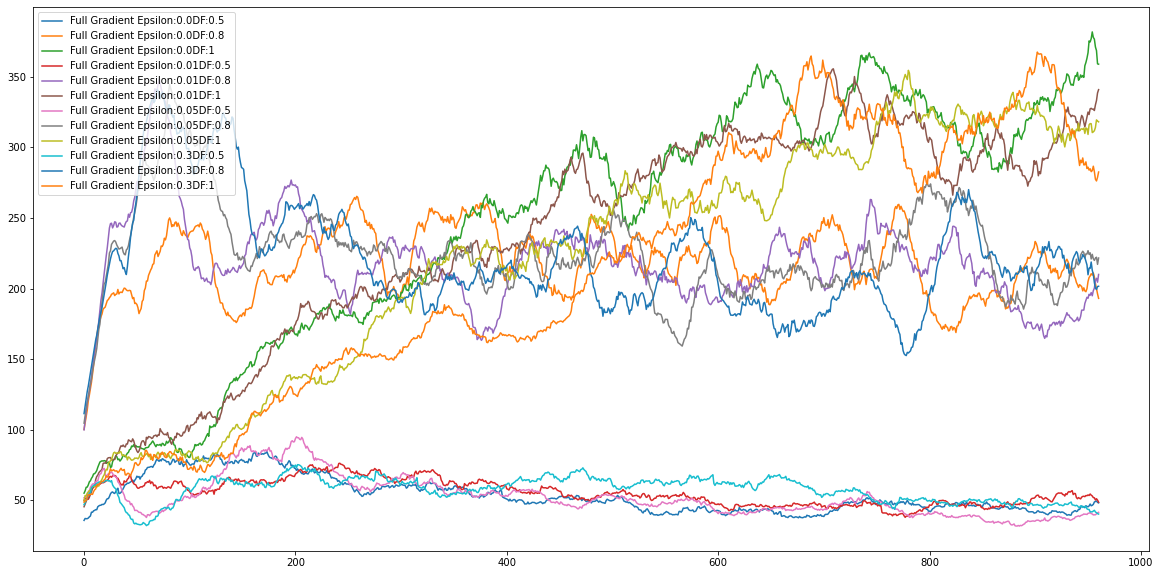

In [84]:
plt.figure(figsize=(20,10))
for semib in [False]:
    for eps in results11['Epsilon'].unique():
        for dis in results11['DisFactor'].unique():
            cond1=results11['SemiB']==semib
            if semib==True:
                la='Semi Gradient'
            else:
                la='Full Gradient'
            cond2=results11['Epsilon']==eps
            cond3=results11['DisFactor']==dis
            x=results12.loc[cond1&cond2&cond3].median().T.values
            plt.plot(x,label=la+' Epsilon:'+str(eps)+ 'DF:'+str(dis))
plt.legend()


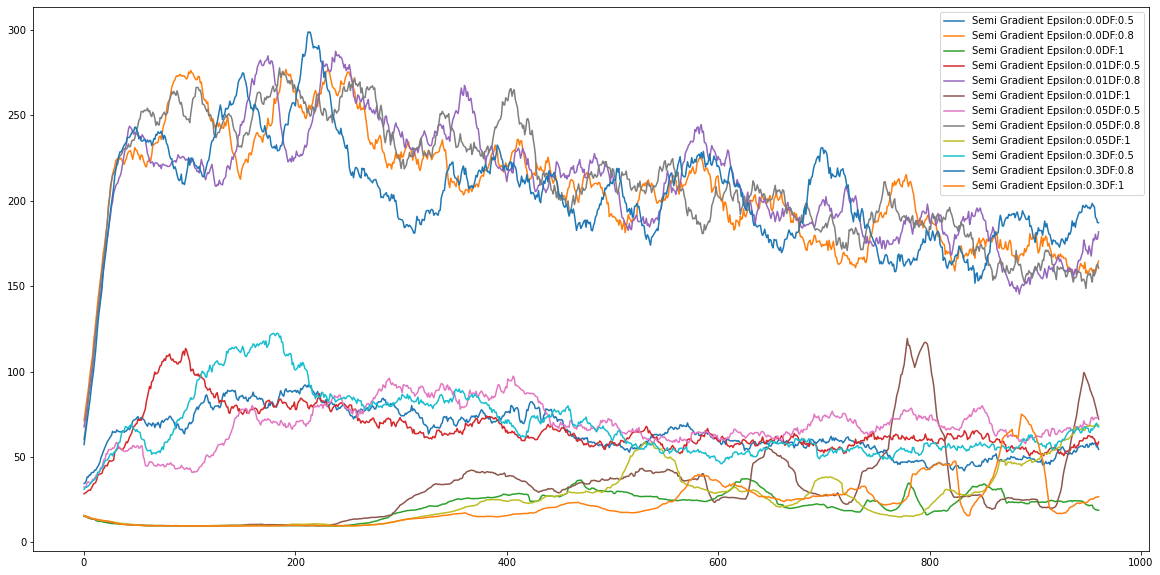

In [85]:
plt.figure(figsize=(20,10))
for semib in [True]:
    for eps in results11['Epsilon'].unique():
        for dis in results11['DisFactor'].unique():
            cond1=results11['SemiB']==semib
            if semib==True:
                la='Semi Gradient'
            else:
                la='Full Gradient'
            cond2=results11['Epsilon']==eps
            cond3=results11['DisFactor']==dis
            x=results12.loc[cond1&cond2&cond3].median().T.values
            plt.plot(x,label=la+' Epsilon:'+str(eps)+ 'DF:'+str(dis))
plt.legend()


Text(0.5, 1.0, 'Episode durations per episode')

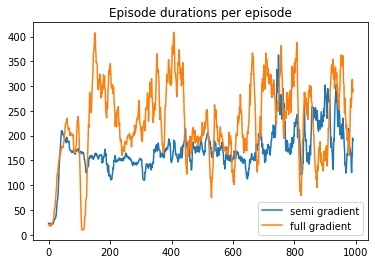

In [31]:
plt.plot(smooth(episode_durations, 10),label='semi gradient')
plt.plot(smooth(episode_durations1, 10),label='full gradient')
plt.legend()
plt.title('Episode durations per episode')

If you want to test/submit your solution **restart the kernel, run all cells and submit the dqn_autograde.py file into codegrade.**